<div style="
    padding: 18px;
    background-color: #03045e;
    border-radius: 12px;
    text-align: center;
    color: white;
">

<!-- Load Rajdhani font -->
<link href="https://fonts.googleapis.com/css2?family=Rajdhani:wght@500;700&display=swap" rel="stylesheet">

<!-- Title -->
<div style="
    font-family: 'Rajdhani', sans-serif;
    font-size: 36px;
    font-weight: 700;
">
    DHARMA
</div>

<!-- Tagline -->
<div style="
    font-family: 'Rajdhani', sans-serif;
    font-size: 16px;
    font-weight: 500;
    opacity: 0.75;
">
    Distributed Hybrid Architecture for Responsible Model Alignment and Assured Privacy
</div>

</div>


<div style="
    background-color:#caf0f8;
    padding:18px;
    font-size:16px;
    font-weight: 500;
    color:#001d3d;
    border-radius:12px;
">

<link href="https://fonts.googleapis.com/css2?family=Rajdhani:wght@500;700&display=swap" rel="stylesheet">

<div style="font-family:'Rajdhani', sans-serif; line-height: 1.5;">

# **Project Overview**
This notebook simulates a critical medical infrastructure operating under adversarial stress. We evaluate the proposed **DHARMA** framework through a series of controlled adversarial attack scenarios designed to test its robustness and resilience. These adversarial behaviors may arise unintentionally, for example due to device malfunctions or corrupted local training processes, as well as intentionally through external attack injections aimed at exploiting learned representations or manipulating data distributions.

<hr style="border:0.5px dashed black; margin:18px 0;">

### **1. The Architecture:**
We implement a **Hybrid Vertical Federated Learning (VFL)** system that mirrors real-world clinical workflows. The architecture is split into two distinct, privacy-preserving clients:

* **Image Client:** This represents the edge hardware which can be a **Digital Dermatoscope** or **optical scanner** interacting directly with the patient's skin. In the real world, this sensor is the primary attack surface. It is vulnerable to physical defects (lens scratches), environmental noise (sensor calibration errors), and adversarial perturbations (invisible frequency triggers).
* **Tabular Client:** This represents the hospital's Electronic Health Record (EHR) system, holding secure metadata like Age, Sex, and Anatomical Site.

In VFL, these clients do not share raw data; they share **Representations (Embeddings)**. These embeddings are mathematically "rich" and they contain highly condensed information. We will investigate to what extent this richness can be exploited by hackers and increase the vulnerability of the framework.

### **2. The Baseline:**
Before we attack the system, we must prove it works. The **HAM10000 dataset** is the gold standard for skin lesion analysis, but it presents a severe challenge: **Extreme Class Imbalance**.
* **The Reality:** Common conditions like **Melanocytic nevi (NV)** vastly outnumber deadly cases like **Melanoma (MEL)** or rare carcinomas **(VASC, DF)**.
* **The Achievement:** The first phase of this notebook demonstrates how our Hybrid VFL framework overcomes this bias. By leveraging cross-modal attention and alignment regularization, we achieve **solid Balanced Accuracy across all 7 classes**, ensuring that the model does not just memorize the majority class but actually learns to detect the rare, lethal cases.

### **3. The Stress Test:**
Once the baseline is established, we transition to **Adversarial Stress Testing**. We treat the trained model as a "black box" and subject it to a battery of sophisticated attacks to audit its safety:

1. **UNTARGETED NOISE ATTACK**
2. **TARGETED LABEL-FLIPPING ATTACK**
3. **UNTARGETED MODEL POISONING**
4. **TARGETED BACKDOOR ATTACK**
5. **MEMBERSHIP INFERENCE ATTACK**
6. **WAVEATTACK**
7. **IMAGE DATA RECONSTRUCTION**
8. **TABULAR DATA RECONSTRUCTION**


**Objective:** The goal of this analysis is to systematically characterize the effectiveness of each adversarial attack by quantifying its impact and identifying its specific injection point and failure mechanism within the DHARMA pipeline. By understanding how and where each attack succeeds, this study establishes a principled foundation for refining existing defenses and guiding the design of more robust and targeted protection mechanisms in future medical AI systems.

</div>
</div>

# <div style="padding:18px;background-color:#03045e;border-radius:12px;text-align:center;color:white;font-family:'Rajdhani',sans-serif;font-size:36px;font-weight:700;">Setup and Data</div>

<div style="
    background-color:#caf0f8;
    padding:18px;
    font-size:16px;
    font-weight: 500;
    color:#001d3d;
    border-radius:12px;
">

<link href="https://fonts.googleapis.com/css2?family=Rajdhani:wght@500;700&display=swap" rel="stylesheet">

<div style="font-family:'Rajdhani', sans-serif; line-height: 1.5;">

## **Importing Libraries**
Any successful experimental notebook relies on a clear understanding of the tools and libraries used.
In this section, we import all required Python libraries for data handling, model construction, training, evaluation, visualization, and security analysis. These libraries form the foundation of the DHARMA experimental pipeline.

In [109]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import (Input, Concatenate, Dense, Dropout, 
                                     LayerNormalization, MultiHeadAttention, 
                                     Reshape, Flatten, Conv2D, Conv2DTranspose,
                                     BatchNormalization, LeakyReLU)
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import balanced_accuracy_score, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import pickle
import time
import warnings
import os
from IPython.display import HTML, display

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)
warnings.filterwarnings('ignore')
print("Imports loaded successfully")

Imports loaded successfully


<div style="
    background-color:#caf0f8;
    padding:18px;
    font-size:16px;
    font-weight: 500;
    color:#001d3d;
    border-radius:12px;
">

<link href="https://fonts.googleapis.com/css2?family=Rajdhani:wght@500;700&display=swap" rel="stylesheet">

<div style="font-family:'Rajdhani', sans-serif; line-height: 1.5;">

## **Configuring Caching System**
As the **DHARMA** framework employs a deep and custom CNN to extract dual embeddings from multiple clients, a full training cycle can take several hours. To address this, we design a caching mechanism that:

1. **Loads previously trained models when available**
2. **Restores precomputed embeddings from disk**
3. **Avoids redundant retraining across notebook executions**

This strategy enables **fast**, **reproducible**, and **resource-efficient** experimentation, while preserving the integrity of the original training process.

In [2]:
ENABLE_CACHING = True
INPUT_DATASET_DIR = '/kaggle/input/hybridvfl-exp-4/'
WORKING_DIR = '/kaggle/working/'
CACHE_DIR = '/kaggle/working/cache/'

# Asset names
ASSET_NAMES = {
    'dual_image_client': 'exp4_dual_image_client.keras',
    'dual_tabular_client': 'exp4_dual_tabular_client.keras',
    'transformer_server': 'exp4_transformer_server.keras',
    'training_history': 'cache/training_history.pkl',
    'train_embeddings': 'cache/train_embeddings.npz',
    'test_embeddings': 'cache/test_embeddings.npz',
    'final_results': 'exp4_results.pkl',
}

os.makedirs(CACHE_DIR, exist_ok=True)
print("Cache configuration initialized")

Cache configuration initialized


In [3]:
def find_asset(asset_name):
    """Find asset in input dataset first, then working dir. Returns path or None."""
    # Check input dataset (uploaded pre-trained)
    input_path = INPUT_DATASET_DIR + ASSET_NAMES[asset_name]
    if os.path.isfile(input_path):
        return input_path
    
    # Check working directory (current session)
    if asset_name in ['training_history', 'train_embeddings', 'test_embeddings']:
        working_path = CACHE_DIR + ASSET_NAMES[asset_name].replace('cache/', '')
    else:
        working_path = WORKING_DIR + ASSET_NAMES[asset_name]
    
    if os.path.isfile(working_path):
        return working_path
    
    return None

def get_save_path(asset_name):
    """Get path for saving asset (always to working dir)."""
    if asset_name in ['training_history', 'train_embeddings', 'test_embeddings']:
        return CACHE_DIR + ASSET_NAMES[asset_name].replace('cache/', '')
    else:
        return WORKING_DIR + ASSET_NAMES[asset_name]

def all_models_exist():
    return all([
        find_asset('dual_image_client') is not None,
        find_asset('dual_tabular_client') is not None,
        find_asset('transformer_server') is not None
    ])

def check_training_completed():
    return all_models_exist() and find_asset('final_results') is not None

def embeddings_cached():
    return (find_asset('test_embeddings') is not None and
            find_asset('train_embeddings') is not None)

def print_checkpoint_status():
    print("Asset status (Input → Working):")
    # Find the maximum length of asset names for alignment
    max_name_length = max(len(name) for name in ASSET_NAMES.keys())
    
    for name in ASSET_NAMES.keys():
        path = find_asset(name)
        if path:
            location = "INPUT" if INPUT_DATASET_DIR in path else "WORKING"
            # Pad the asset name to align "FOUND in" messages
            padded_name = name.ljust(max_name_length)
            print(f"  {padded_name}: FOUND in {location}")
        else:
            padded_name = name.ljust(max_name_length)
            print(f"  {padded_name}: MISSING")

print("Utility functions defined")

Utility functions defined


In [4]:
FORCE_RETRAIN = False
FORCE_RECOMPUTE_EMBEDDINGS = False
CLEAR_ALL_CACHE = False

if CLEAR_ALL_CACHE:
    import shutil
    if os.path.exists(CACHE_DIR):
        shutil.rmtree(CACHE_DIR)
    os.makedirs(CACHE_DIR, exist_ok=True)
    for asset in ['dual_image_client', 'dual_tabular_client', 'transformer_server', 'final_results']:
        path = get_save_path(asset)
        if os.path.exists(path):
            os.remove(path)
    print("All cache cleared")
else:
    print("Cache control initialized")
    print_checkpoint_status()

Cache control initialized
Asset status (Input → Working):
  dual_image_client  : FOUND in INPUT
  dual_tabular_client: FOUND in INPUT
  transformer_server : FOUND in INPUT
  training_history   : FOUND in INPUT
  train_embeddings   : FOUND in INPUT
  test_embeddings    : FOUND in INPUT
  final_results      : FOUND in INPUT


<div style="
    background-color:#caf0f8;
    padding:18px;
    font-size:16px;
    font-weight: 500;
    color:#001d3d;
    border-radius:12px;
">

<link href="https://fonts.googleapis.com/css2?family=Rajdhani:wght@500;700&display=swap" rel="stylesheet">

<div style="font-family:'Rajdhani', sans-serif; line-height: 1.5;">

## **Loading Data**
The original HAM10000 dataset consists of:

* **Image directories containing dermoscopic samples**
* **A metadata** `.csv` **file that represents the raw participant information**

In this section, we load and organize the required image files, metadata, and directory structures, ensuring consistent alignment between image and tabular modalities for downstream training and evaluation.

In [5]:
BASE_PATH_EXP1 = '/kaggle/input/hybridvfl-exp-1/'
BASE_PATH_EXP2 = '/kaggle/input/hybridvfl-exp-2/'
BASE_PATH_EXP3 = '/kaggle/input/hybridvfl-exp-3/'

image_model = load_model(BASE_PATH_EXP1 + 'best_image_model.keras')

X_train = np.load(BASE_PATH_EXP1 + 'X_train.npy')
X_test = np.load(BASE_PATH_EXP1 + 'X_test.npy')
y_train = np.load(BASE_PATH_EXP1 + 'y_train.npy')
y_test = np.load(BASE_PATH_EXP1 + 'y_test.npy')

train_tabular_features = np.load(BASE_PATH_EXP2 + 'train_tabular_features.npy')
test_tabular_features = np.load(BASE_PATH_EXP2 + 'test_tabular_features.npy')

with open(BASE_PATH_EXP1 + 'class_weight_dict.pkl', 'rb') as f:
    class_weight_dict = pickle.load(f)

with open(BASE_PATH_EXP2 + 'exp1_2_results.pkl', 'rb') as f:
    prev_results = pickle.load(f)

with open(BASE_PATH_EXP3 + 'exp3_results.pkl', 'rb') as f:
    exp3_results = pickle.load(f)

total_data_mb = (X_train.nbytes + X_test.nbytes + train_tabular_features.nbytes + test_tabular_features.nbytes) / (1024**2)
print(f"Data loaded to RAM: {X_train.shape[0]} train, {X_test.shape[0]} test samples ({total_data_mb:.1f} MB)")

I0000 00:00:1766496745.965738   11462 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Data loaded to RAM: 21252 train, 5313 test samples (763.9 MB)


<div style="
    background-color:#caf0f8;
    padding:18px;
    font-size:16px;
    font-weight: 500;
    color:#001d3d;
    border-radius:12px;
">

<link href="https://fonts.googleapis.com/css2?family=Rajdhani:wght@500;700&display=swap" rel="stylesheet">

<div style="font-family:'Rajdhani', sans-serif; line-height: 1.5;">

## **Framework Design**
The DHARMA framework is implemented using a custom **TensorFlow/Keras** architecture and introduces **multimodal collaboration** between image-based and tabular participants.

Key design characteristics include:

1. **Modality-specific and modality-invariant embedding extraction at each client**
2. **Secure transmission of embeddings instead of raw data**
3. **Alignment and fusion of embeddings at a cross-modal transformer server**

The following figure illustrates the overall system architecture and interaction between clients and the server:
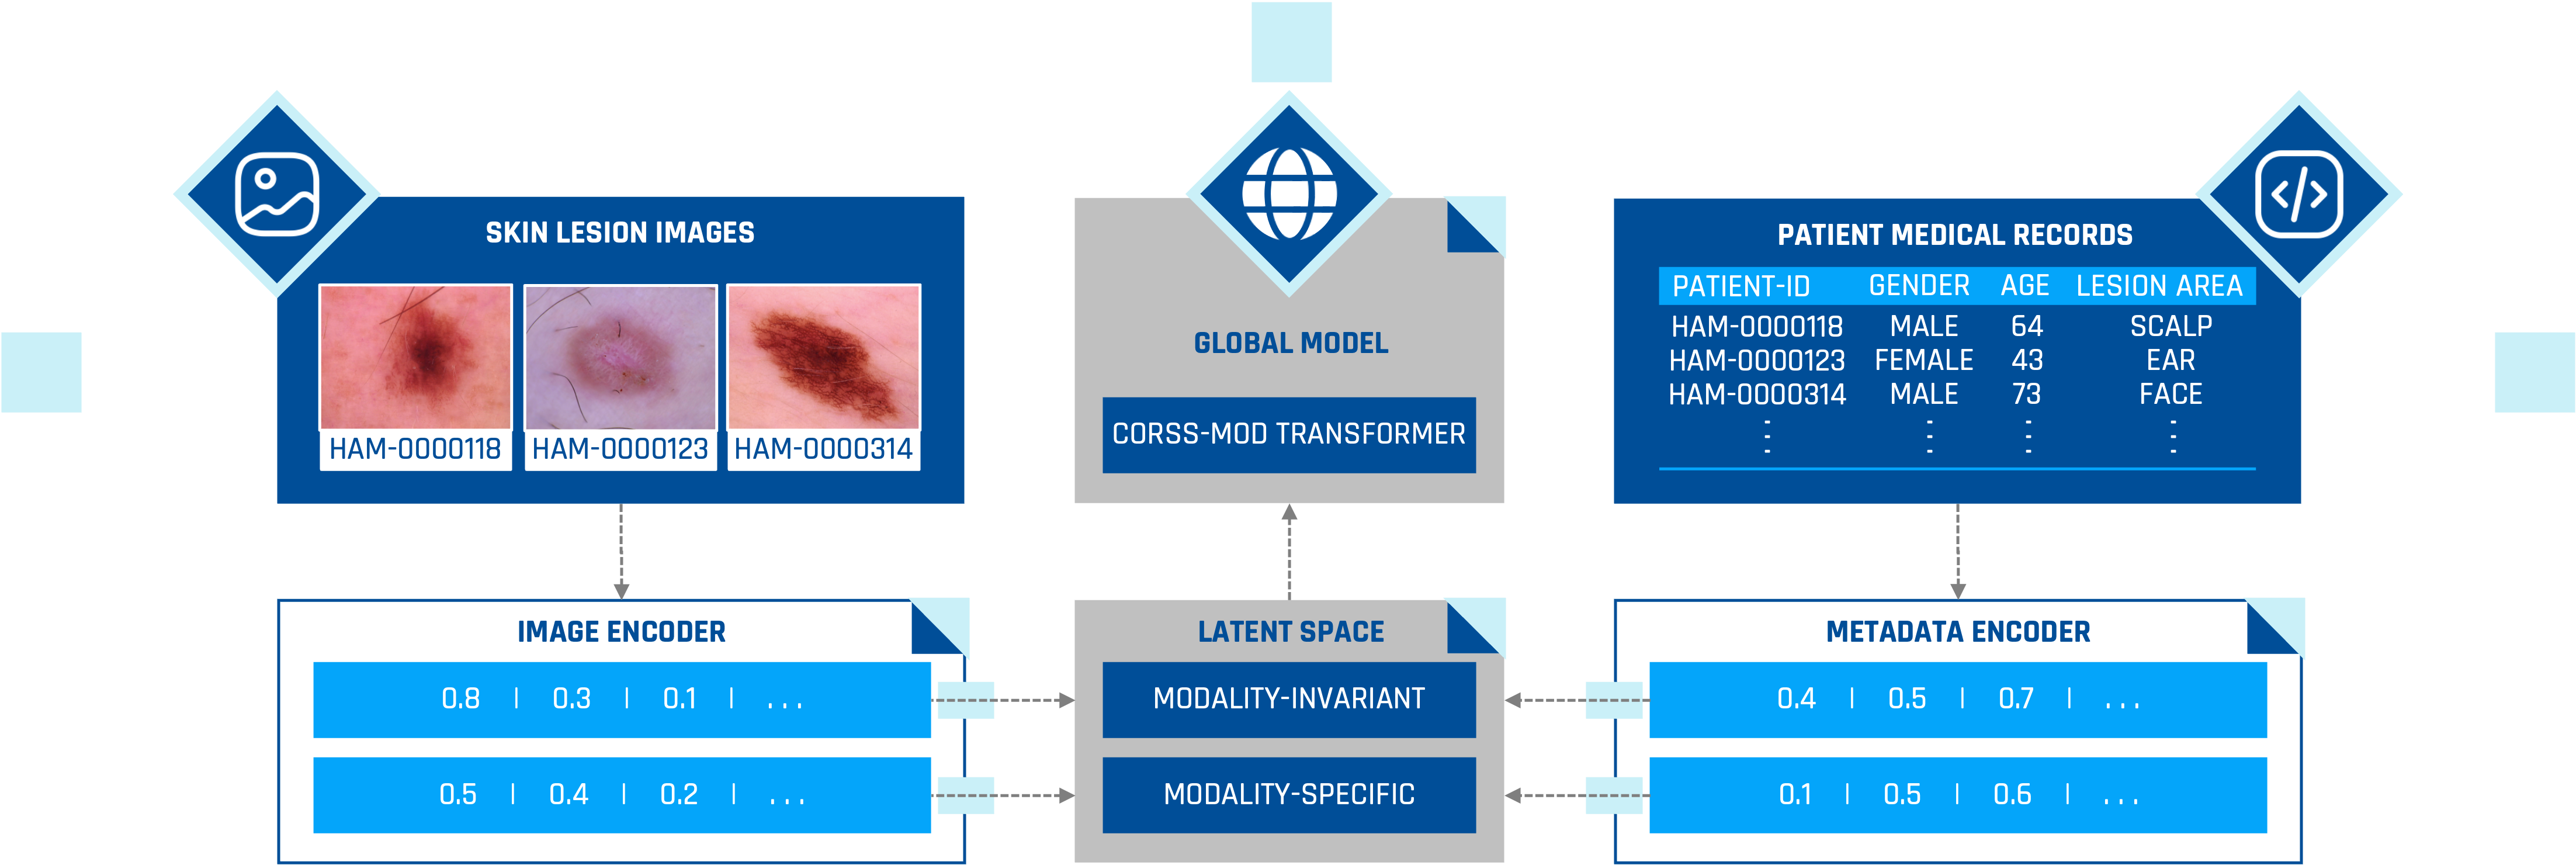

In [7]:
# Check if trained models exist
if ENABLE_CACHING and all_models_exist() and not FORCE_RETRAIN:
    img_path = find_asset('dual_image_client')
    tab_path = find_asset('dual_tabular_client')
    server_path = find_asset('transformer_server')
    
    print(f"Loading pre-trained models from {'INPUT' if INPUT_DATASET_DIR in img_path else 'WORKING'}")
    dual_image_client = load_model(img_path)
    dual_tabular_client = load_model(tab_path)
    transformer_server = load_model(server_path)
    
    optimizer_img = Adam(learning_rate=0.0001)
    optimizer_tab = Adam(learning_rate=0.0001)
    optimizer_server = Adam(learning_rate=0.0001)
    
    print("Models loaded successfully")
else:
    print("Building models from scratch")
    
    # Base image model extraction
    if hasattr(image_model, 'input') and image_model.input is not None:
        model_input = image_model.input
    else:
        model_input = image_model.layers[0].input

    feature_layer = None
    for layer in image_model.layers:
        if isinstance(layer, tf.keras.layers.MaxPooling2D):
            feature_layer = layer
            if 'max_pooling2d_2' in layer.name:
                break

    if feature_layer is None or 'max_pooling2d_2' not in feature_layer.name:
        maxpool_layers = [layer for layer in image_model.layers if isinstance(layer, tf.keras.layers.MaxPooling2D)]
        if len(maxpool_layers) >= 2:
            feature_layer = maxpool_layers[1]
        else:
            feature_layer = maxpool_layers[0]

    base_image_model = Model(
        inputs=model_input,
        outputs=feature_layer.output,
        name='ImageBase'
    )

    for layer in base_image_model.layers:
        layer.trainable = False

    # Dual Image Client
    image_input = Input(shape=(100, 100, 3), name='image_input')
    base_features = base_image_model(image_input)
    base_flat = Flatten(name='image_flatten')(base_features)

    specific_img = Dense(2048, activation='relu', name='img_specific_dense1')(base_flat)
    specific_img = Dropout(0.3, name='img_specific_dropout1')(specific_img)
    specific_img_output = Dense(1024, activation='relu', name='img_specific_output')(specific_img)

    invariant_img = Dense(512, activation='relu', name='img_invariant_dense1')(base_flat)
    invariant_img = Dropout(0.2, name='img_invariant_dropout1')(invariant_img)
    invariant_img_output = Dense(256, activation='relu', name='img_invariant_output')(invariant_img)

    dual_image_client = Model(
        inputs=image_input,
        outputs=[specific_img_output, invariant_img_output],
        name='DualImageClient'
    )

    # Dual Tabular Client
    tabular_input = Input(shape=(train_tabular_features.shape[1],), name='tabular_input')

    specific_tab = Dense(128, activation='relu', name='tab_specific_dense1')(tabular_input)
    specific_tab = Dropout(0.3, name='tab_specific_dropout1')(specific_tab)
    specific_tab_output = Dense(64, activation='relu', name='tab_specific_output')(specific_tab)

    invariant_tab = Dense(128, activation='relu', name='tab_invariant_dense1')(tabular_input)
    invariant_tab = Dropout(0.2, name='tab_invariant_dropout1')(invariant_tab)
    invariant_tab_output = Dense(256, activation='relu', name='tab_invariant_output')(invariant_tab)

    dual_tabular_client = Model(
        inputs=tabular_input,
        outputs=[specific_tab_output, invariant_tab_output],
        name='DualTabularClient'
    )

    # Transformer Server
    spec_img_input = Input(shape=(1024,), name='server_spec_img_input')
    inv_img_input = Input(shape=(256,), name='server_inv_img_input')
    spec_tab_input = Input(shape=(64,), name='server_spec_tab_input')
    inv_tab_input = Input(shape=(256,), name='server_inv_tab_input')

    spec_img_proj = Dense(128, activation='relu', name='spec_img_proj')(spec_img_input)
    spec_tab_proj = Dense(128, activation='relu', name='spec_tab_proj')(spec_tab_input)

    spec_img_seq = Reshape((1, 128), name='spec_img_seq')(spec_img_proj)
    spec_tab_seq = Reshape((1, 128), name='spec_tab_seq')(spec_tab_proj)

    feature_sequence = Concatenate(axis=1, name='feature_sequence')([spec_img_seq, spec_tab_seq])

    attention_layer = MultiHeadAttention(
        num_heads=4, 
        key_dim=32, 
        dropout=0.1,
        name='cross_modal_attention'
    )
    attended = attention_layer(feature_sequence, feature_sequence)

    attended = LayerNormalization(epsilon=1e-6, name='attention_layernorm')(attended)

    attended_flat = Flatten(name='attended_flatten')(attended)

    final_features = Concatenate(name='final_features')([
        attended_flat,
        inv_img_input,
        inv_tab_input
    ])

    x_server = Dense(4096, activation='relu', name='server_fc1')(final_features)
    x_server = Dropout(0.5, name='server_dropout1')(x_server)
    x_server = Dense(4096, activation='relu', name='server_fc2')(x_server)
    x_server = Dropout(0.5, name='server_dropout2')(x_server)
    server_output = Dense(7, activation='softmax', name='server_output')(x_server)

    transformer_server = Model(
        inputs=[spec_img_input, inv_img_input, spec_tab_input, inv_tab_input],
        outputs=server_output,
        name='TransformerServer'
    )

    optimizer_img = Adam(learning_rate=0.0001)
    optimizer_tab = Adam(learning_rate=0.0001)
    optimizer_server = Adam(learning_rate=0.0001)

    transformer_server.compile(
        optimizer=optimizer_server,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    print("Models built successfully")

Loading pre-trained models from INPUT
Models loaded successfully


# <div style="padding:18px;background-color:#03045e;border-radius:12px;text-align:center;color:white;font-family:'Rajdhani',sans-serif;font-size:36px;font-weight:700;">Model Configuration</div>

<div style="
    background-color:#caf0f8;
    padding:18px;
    font-size:16px;
    font-weight: 500;
    color:#001d3d;
    border-radius:12px;
">

<link href="https://fonts.googleapis.com/css2?family=Rajdhani:wght@500;700&display=swap" rel="stylesheet">

<div style="font-family:'Rajdhani', sans-serif; line-height: 1.5;">

## **Training**
If no pre-trained model or cached embeddings are detected, the notebook automatically executes a full training pipeline, including:

* **Model training**
* **Validation**
* **Final testing**

This design allows the framework to operate both as a **full training environment** and as a **lightweight evaluation platform** when cached assets are available.

In [8]:
VFL4_EPOCHS = 50
VFL4_BATCH_SIZE = 32
LAMBDA_ALIGNMENT = 0.5

num_train_samples = len(X_train)
num_batches = num_train_samples // VFL4_BATCH_SIZE

# Check if training already completed with correct number of epochs
skip_training = False
history_path = find_asset('training_history')
if ENABLE_CACHING and history_path is not None and not FORCE_RETRAIN:
    with open(history_path, 'rb') as f:
        history_data = pickle.load(f)
    
    # Check if saved epochs match requested epochs
    if len(history_data['train_loss']) == VFL4_EPOCHS:
        vfl4_train_loss_history = history_data['train_loss']
        vfl4_train_acc_history = history_data['train_acc']
        vfl4_val_loss_history = history_data['val_loss']
        vfl4_val_acc_history = history_data['val_acc']
        vfl4_class_loss_history = history_data['class_loss']
        vfl4_align_loss_history = history_data['align_loss']
        vfl4_comm_costs_upload = history_data['comm_upload']
        vfl4_comm_costs_download = history_data['comm_download']
        vfl4_total_time = history_data['total_time']
        skip_training = True
        location = 'INPUT' if INPUT_DATASET_DIR in history_path else 'WORKING'
        print(f"Training already completed for {VFL4_EPOCHS} epochs, loading from {location}")
    else:
        print(f"Found {len(history_data['train_loss'])} epochs, but {VFL4_EPOCHS} requested, retraining")

if not skip_training:
    print("Starting training with optimized data pipeline")
    vfl4_train_loss_history = []
    vfl4_train_acc_history = []
    vfl4_val_loss_history = []
    vfl4_val_acc_history = []
    vfl4_class_loss_history = []
    vfl4_align_loss_history = []
    vfl4_comm_costs_upload = []
    vfl4_comm_costs_download = []
    
    # Create optimized tf.data.Dataset pipeline
    train_dataset = tf.data.Dataset.from_tensor_slices((
        X_train,
        train_tabular_features,
        y_train
    ))
    train_dataset = train_dataset.shuffle(buffer_size=num_train_samples, seed=RANDOM_STATE)
    train_dataset = train_dataset.batch(VFL4_BATCH_SIZE, drop_remainder=False)
    train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)
    
    print(f"Data pipeline created: {num_train_samples} samples, {num_batches} batches")

    vfl4_start_time = time.time()

    for epoch in range(VFL4_EPOCHS):
        epoch_start = time.time()
        epoch_loss = 0
        epoch_class_loss = 0
        epoch_align_loss = 0
        epoch_acc = 0
        epoch_upload_cost = 0
        epoch_download_cost = 0
        
        batch_count = 0
        for X_batch, X_tab_batch, y_batch in train_dataset:
            with tf.GradientTape(persistent=True) as client_tape:
                spec_img, inv_img = dual_image_client(X_batch, training=True)
                spec_tab, inv_tab = dual_tabular_client(X_tab_batch, training=True)
            
            upload_cost = (spec_img.numpy().nbytes + inv_img.numpy().nbytes + 
                           spec_tab.numpy().nbytes + inv_tab.numpy().nbytes) / (1024 * 1024)
            epoch_upload_cost += upload_cost
            
            with tf.GradientTape(persistent=True) as server_tape:
                predictions = transformer_server([spec_img, inv_img, spec_tab, inv_tab], training=True)
                
                sample_weights = np.array([class_weight_dict[np.argmax(y)] for y in y_batch])
                class_loss = tf.keras.losses.categorical_crossentropy(y_batch, predictions)
                class_loss = tf.reduce_mean(class_loss * sample_weights)
                
                alignment_loss = tf.reduce_mean(tf.square(inv_img - inv_tab))
                
                total_loss = class_loss + LAMBDA_ALIGNMENT * alignment_loss
            
            server_grads = server_tape.gradient(total_loss, transformer_server.trainable_variables)
            optimizer_server.apply_gradients(zip(server_grads, transformer_server.trainable_variables))
            
            grad_spec_img = server_tape.gradient(total_loss, spec_img)
            grad_inv_img = server_tape.gradient(total_loss, inv_img)
            grad_spec_tab = server_tape.gradient(total_loss, spec_tab)
            grad_inv_tab = server_tape.gradient(total_loss, inv_tab)
            
            del server_tape
            
            download_size = 0
            for grad in [grad_spec_img, grad_inv_img, grad_spec_tab, grad_inv_tab]:
                if grad is not None:
                    download_size += grad.numpy().nbytes
            download_cost = download_size / (1024 * 1024)
            epoch_download_cost += download_cost
            
            if grad_spec_img is not None and grad_inv_img is not None:
                img_grads = client_tape.gradient(
                    [spec_img, inv_img],
                    dual_image_client.trainable_variables,
                    output_gradients=[grad_spec_img, grad_inv_img]
                )
                if img_grads and any(g is not None for g in img_grads):
                    optimizer_img.apply_gradients(zip(
                        [g for g in img_grads if g is not None],
                        [v for v, g in zip(dual_image_client.trainable_variables, img_grads) if g is not None]
                    ))
            
            if grad_spec_tab is not None and grad_inv_tab is not None:
                tab_grads = client_tape.gradient(
                    [spec_tab, inv_tab],
                    dual_tabular_client.trainable_variables,
                    output_gradients=[grad_spec_tab, grad_inv_tab]
                )
                if tab_grads and any(g is not None for g in tab_grads):
                    optimizer_tab.apply_gradients(zip(
                        [g for g in tab_grads if g is not None],
                        [v for v, g in zip(dual_tabular_client.trainable_variables, tab_grads) if g is not None]
                    ))
            
            del client_tape
            
            epoch_loss += total_loss.numpy()
            epoch_class_loss += class_loss.numpy()
            epoch_align_loss += alignment_loss.numpy()
            batch_acc = np.mean(np.argmax(predictions.numpy(), axis=1) == np.argmax(y_batch, axis=1))
            epoch_acc += batch_acc
            batch_count += 1
        
        avg_loss = epoch_loss / batch_count
        avg_class_loss = epoch_class_loss / batch_count
        avg_align_loss = epoch_align_loss / batch_count
        avg_acc = epoch_acc / batch_count
        
        val_spec_img, val_inv_img = dual_image_client.predict(X_test, verbose=0)
        val_spec_tab, val_inv_tab = dual_tabular_client.predict(test_tabular_features, verbose=0)
        val_predictions = transformer_server.predict([val_spec_img, val_inv_img, val_spec_tab, val_inv_tab], verbose=0)
        val_loss = tf.keras.losses.categorical_crossentropy(y_test, val_predictions).numpy().mean()
        val_acc = np.mean(np.argmax(val_predictions, axis=1) == np.argmax(y_test, axis=1))
        
        vfl4_train_loss_history.append(avg_loss)
        vfl4_train_acc_history.append(avg_acc)
        vfl4_val_loss_history.append(val_loss)
        vfl4_val_acc_history.append(val_acc)
        vfl4_class_loss_history.append(avg_class_loss)
        vfl4_align_loss_history.append(avg_align_loss)
        vfl4_comm_costs_upload.append(epoch_upload_cost)
        vfl4_comm_costs_download.append(epoch_download_cost)
        
        print(f"Epoch {epoch+1}/{VFL4_EPOCHS} - loss: {avg_loss:.4f} - acc: {avg_acc:.4f} - val_loss: {val_loss:.4f} - val_acc: {val_acc:.4f}")

    vfl4_total_time = time.time() - vfl4_start_time

    dual_image_client.save(get_save_path('dual_image_client'))
    dual_tabular_client.save(get_save_path('dual_tabular_client'))
    transformer_server.save(get_save_path('transformer_server'))
    
    history_data = {
        'train_loss': vfl4_train_loss_history,
        'train_acc': vfl4_train_acc_history,
        'val_loss': vfl4_val_loss_history,
        'val_acc': vfl4_val_acc_history,
        'class_loss': vfl4_class_loss_history,
        'align_loss': vfl4_align_loss_history,
        'comm_upload': vfl4_comm_costs_upload,
        'comm_download': vfl4_comm_costs_download,
        'total_time': vfl4_total_time
    }
    
    with open(get_save_path('training_history'), 'wb') as f:
        pickle.dump(history_data, f)
    
    print(f"Training completed in {vfl4_total_time/60:.2f} minutes, models saved to WORKING")

Training already completed for 50 epochs, loading from INPUT


In [111]:
# Compute or load embeddings
if ENABLE_CACHING and embeddings_cached() and not FORCE_RECOMPUTE_EMBEDDINGS:
    test_emb_path = find_asset('test_embeddings')
    train_emb_path = find_asset('train_embeddings')
    location = 'INPUT' if INPUT_DATASET_DIR in test_emb_path else 'WORKING'
    print(f"Loading cached embeddings from {location}")
    
    test_embeddings = np.load(test_emb_path)
    test_spec_img = test_embeddings['spec_img']
    test_inv_img = test_embeddings['inv_img']
    test_spec_tab = test_embeddings['spec_tab']
    test_inv_tab = test_embeddings['inv_tab']
    
    train_embeddings = np.load(train_emb_path)
    train_spec_img = train_embeddings['spec_img']
    train_inv_img = train_embeddings['inv_img']
    train_spec_tab = train_embeddings['spec_tab']
    train_inv_tab = train_embeddings['inv_tab']
    
    print("Embeddings loaded successfully")
else:
    print("Computing embeddings")
    test_spec_img, test_inv_img = dual_image_client.predict(X_test, verbose=0)
    test_spec_tab, test_inv_tab = dual_tabular_client.predict(test_tabular_features, verbose=0)
    
    train_spec_img, train_inv_img = dual_image_client.predict(X_train, verbose=0)
    train_spec_tab, train_inv_tab = dual_tabular_client.predict(train_tabular_features, verbose=0)
    
    np.savez(get_save_path('test_embeddings'),
             spec_img=test_spec_img, inv_img=test_inv_img,
             spec_tab=test_spec_tab, inv_tab=test_inv_tab)
    
    np.savez(get_save_path('train_embeddings'),
             spec_img=train_spec_img, inv_img=train_inv_img,
             spec_tab=train_spec_tab, inv_tab=train_inv_tab)
    
    print("Embeddings computed and cached to WORKING")

test_predictions = transformer_server.predict([test_spec_img, test_inv_img, test_spec_tab, test_inv_tab], verbose=0)

y_pred = np.argmax(test_predictions, axis=1)
y_true = np.argmax(y_test, axis=1)

vfl4_test_acc = accuracy_score(y_true, y_pred)
vfl4_balanced_acc = balanced_accuracy_score(y_true, y_pred)
vfl4_macro_f1 = f1_score(y_true, y_pred, average='macro')
vfl4_macro_precision = precision_score(y_true, y_pred, average='macro')
vfl4_macro_recall = recall_score(y_true, y_pred, average='macro')

# Build summary table
results_data = [
    {"Metric": "Test Accuracy", "Value": f"{vfl4_test_acc:.4f}"},
    {"Metric": "Balanced Accuracy", "Value": f"{vfl4_balanced_acc:.4f}"},
    {"Metric": "Macro F1", "Value": f"{vfl4_macro_f1:.4f}"},
    {"Metric": "Macro Precision", "Value": f"{vfl4_macro_precision:.4f}"},
    {"Metric": "Macro Recall", "Value": f"{vfl4_macro_recall:.4f}"},
]
df_results = pd.DataFrame(results_data)

html_results = df_results.to_html(index=False, classes='table table-striped table-bordered', table_id='test_metrics')
display(HTML("<h4>Test Performance Metrics</h4>" + html_results))

Loading cached embeddings from INPUT
Embeddings loaded successfully


Metric,Value
Test Accuracy,0.8925
Balanced Accuracy,0.9285
Macro F1,0.9144
Macro Precision,0.9039
Macro Recall,0.9285


<div style="
    background-color:#caf0f8;
    padding:18px;
    font-size:16px;
    font-weight: 500;
    color:#001d3d;
    border-radius:12px;
">

<link href="https://fonts.googleapis.com/css2?family=Rajdhani:wght@500;700&display=swap" rel="stylesheet">

<div style="font-family:'Rajdhani', sans-serif; line-height: 1.5;">

## **Evaluation**
In this stage, the trained model is evaluated on previously unseen samples to assess its generalization capability.

We report performance using:

1. **A confusion matrix to analyze class-wise prediction behavior**
2. **A per-class accuracy bar chart to highlight disparities across lesion types**

This evaluation allows us to distinguish between:

* **A model dominated by a single majority class**
* **A model that is both accurate and fair across classes**

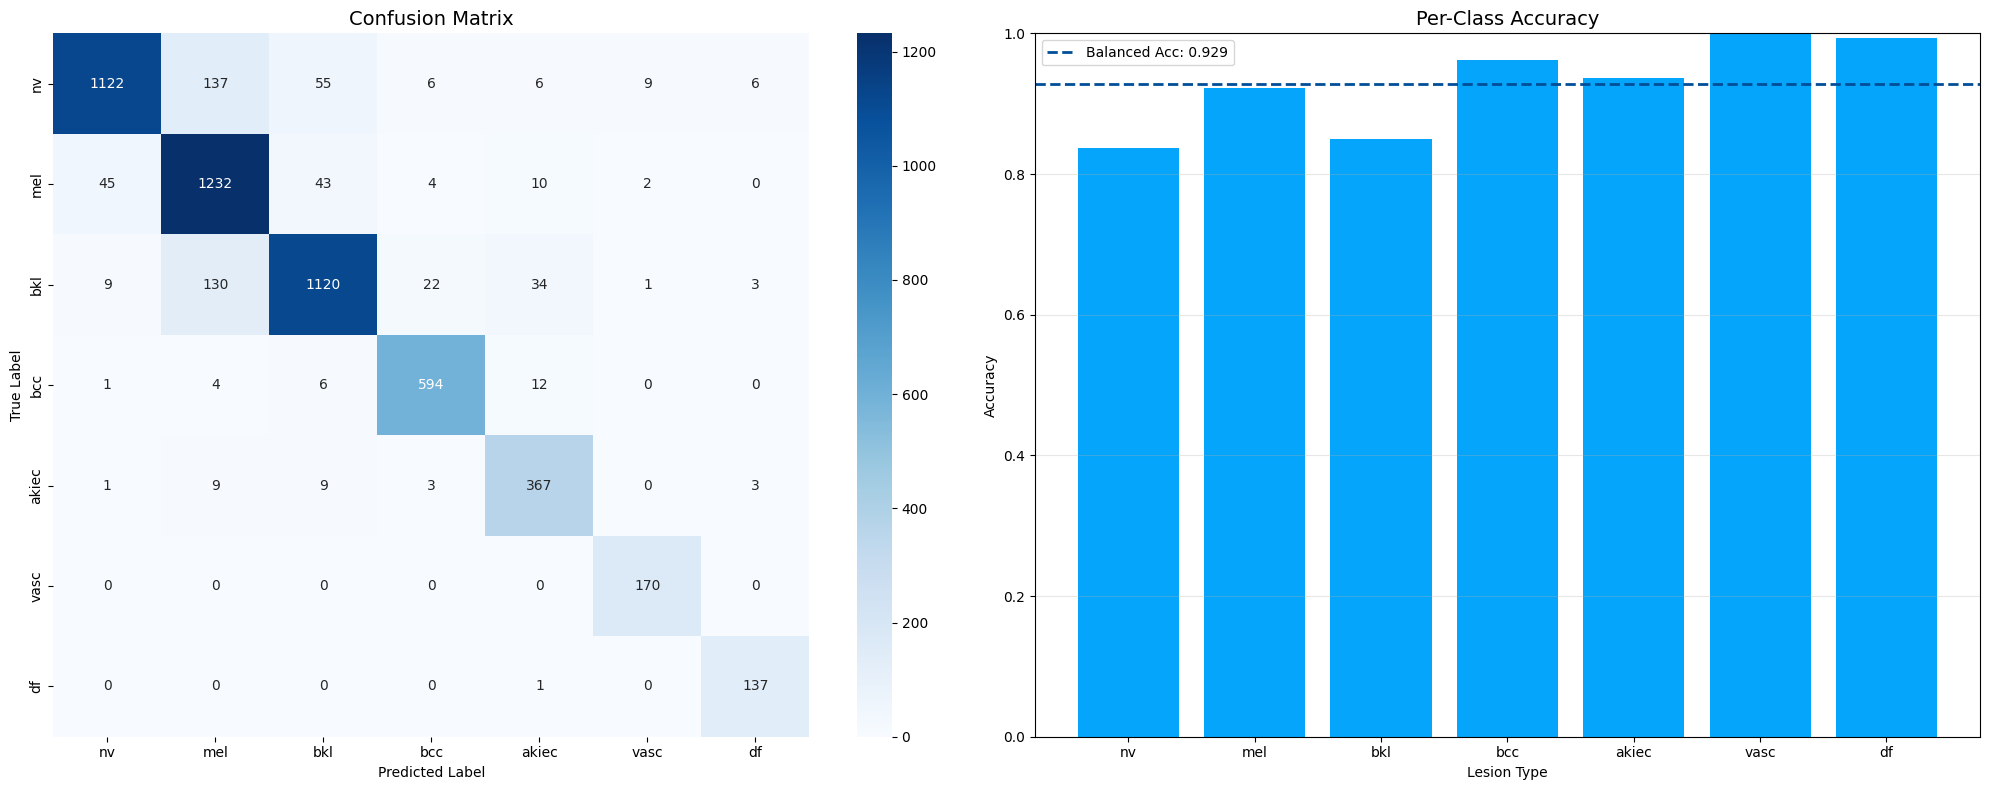

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

lesion_types = ['nv', 'mel', 'bkl', 'bcc', 'akiec', 'vasc', 'df']

cm = confusion_matrix(y_true, y_pred)
per_class_acc = cm.diagonal() / cm.sum(axis=1)

fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Confusion Matrix
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=lesion_types,
    yticklabels=lesion_types,
    ax=axes[0]
)
axes[0].set_title('Confusion Matrix', fontsize=14, fontweight='normal')
axes[0].set_xlabel('Predicted Label')
axes[0].set_ylabel('True Label')

# Per-Class Accuracy
bars = axes[1].bar(
    lesion_types,
    per_class_acc,
    color='#04A5FA',
    alpha=1
)

axes[1].axhline(
    y=vfl4_balanced_acc,
    color='#004E98',
    linestyle='--',
    linewidth=2,
    label=f'Balanced Acc: {vfl4_balanced_acc:.3f}'
)

axes[1].set_xlabel('Lesion Type')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Per-Class Accuracy', fontsize=14, fontweight='normal')
axes[1].set_ylim([0, 1])
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)


plt.tight_layout()
plt.show()

In [11]:
inv_img_test_norm = test_inv_img / (np.linalg.norm(test_inv_img, axis=1, keepdims=True) + 1e-8)
inv_tab_test_norm = test_inv_tab / (np.linalg.norm(test_inv_tab, axis=1, keepdims=True) + 1e-8)

alignment_scores = np.sum(inv_img_test_norm * inv_tab_test_norm, axis=1)
avg_alignment = np.mean(alignment_scores)

exp4_results = {
    'test_accuracy': float(vfl4_test_acc),
    'balanced_accuracy': float(vfl4_balanced_acc),
    'confusion_matrix': cm,
    'training_history': {
        'loss': vfl4_train_loss_history,
        'acc': vfl4_train_acc_history,
        'val_loss': vfl4_val_loss_history,
        'val_acc': vfl4_val_acc_history,
        'class_loss': vfl4_class_loss_history,
        'align_loss': vfl4_align_loss_history,
        'comm_upload': vfl4_comm_costs_upload,
        'comm_download': vfl4_comm_costs_download
    },
    'per_class_accuracy': per_class_acc.tolist(),
    'predictions': y_pred,
    'alignment_stats': {
        'mean': float(avg_alignment),
        'min': float(alignment_scores.min()),
        'max': float(alignment_scores.max()),
        'std': float(alignment_scores.std())
    },
    'hyperparameters': {
        'lambda_alignment': LAMBDA_ALIGNMENT,
        'num_heads': 4,
        'key_dim': 32
    },
    'training_time_minutes': vfl4_total_time / 60,
    'architecture': 'cross_modal_transformer'
}

with open(get_save_path('final_results'), 'wb') as f:
    pickle.dump(exp4_results, f)

print("Results saved successfully")

Results saved successfully


# <div style="padding:18px;background-color:#03045e;border-radius:12px;text-align:center;color:white;font-family:'Rajdhani',sans-serif;font-size:36px;font-weight:700;">Adversarial Stress Analysis</div>

<div style="
    background-color:#caf0f8;
    padding:18px;
    font-size:16px;
    font-weight: 500;
    color:#001d3d;
    border-radius:12px;
">

<link href="https://fonts.googleapis.com/css2?family=Rajdhani:wght@500;700&display=swap" rel="stylesheet">

<div style="font-family:'Rajdhani', sans-serif; line-height: 1.5;">

## **Untargeted Noise Attack**
This attack simulates a compromised or malfunctioning image client that sends random noise instead of valid image data.

We evaluate two noise intensities:

1. `NOISE_SCALE_MILD = 0.2`
2. `NOISE_SCALE_SEVERE = 1.0`

These settings represent realistic failure modes, such as:

* **Mild sensor noise or ISO grain**
* **Severe corruption, e.g., out-of-focus or hardware malfunction**

The goal is to measure how noise magnitude affects model robustness and performance degradation.

In [114]:
NOISE_SCALE_MILD = 0.2  # Mild sensor noise (ISO grain), slight blur
NOISE_SCALE_SEVERE = 1.0  # Dirty/Obstructed lens, out-of-focus image

# Copy original embeddings (keep originals intact)
original_test_spec_img = test_spec_img.copy()
original_test_inv_img = test_inv_img.copy()

# Keep tabular embeddings clean (honest client)
clean_test_spec_tab = test_spec_tab
clean_test_inv_tab = test_inv_tab

# Dictionary to store results for both noise levels
noise_attack_results = {}

# Run attack for both noise levels
for noise_scale, noise_type in [(NOISE_SCALE_MILD, 'mild'), (NOISE_SCALE_SEVERE, 'severe')]:
    # Generate Gaussian noise with same shape as image embeddings
    noise_spec_img = np.random.normal(0, noise_scale, original_test_spec_img.shape)
    noise_inv_img = np.random.normal(0, noise_scale, original_test_inv_img.shape)
    
    # Add noise to image embeddings
    noisy_test_spec_img = original_test_spec_img + noise_spec_img
    noisy_test_inv_img = original_test_inv_img + noise_inv_img
    
    # Run prediction with noisy image + clean tabular
    noise_predictions = transformer_server.predict(
        [noisy_test_spec_img, noisy_test_inv_img, clean_test_spec_tab, clean_test_inv_tab], 
        verbose=0
    )
    
    # Calculate attacked metrics
    y_pred_noise = np.argmax(noise_predictions, axis=1)
    noise_test_acc = accuracy_score(y_true, y_pred_noise)
    noise_balanced_acc = balanced_accuracy_score(y_true, y_pred_noise)
    
    # Calculate per-class accuracy under attack
    cm_noise = confusion_matrix(y_true, y_pred_noise)
    per_class_acc_noise = cm_noise.diagonal() / cm_noise.sum(axis=1)
    
    # Store results
    noise_attack_results[noise_type] = {
        'noise_scale': noise_scale,
        'accuracy': noise_test_acc,
        'balanced_acc': noise_balanced_acc,
        'accuracy_drop': vfl4_test_acc - noise_test_acc,
        'balanced_acc_drop': vfl4_balanced_acc - noise_balanced_acc,
        'per_class_acc': per_class_acc_noise
    }

# Build summary table for noise attack results
noise_results_data = []
for noise_type in ['mild', 'severe']:
    results = noise_attack_results[noise_type]
    noise_results_data.append({
        "Noise Level": noise_type.capitalize(),
        "Noise Scale": f"{results['noise_scale']:.2f}",
        "Original Accuracy": f"{vfl4_test_acc:.4f}",
        "Attacked Accuracy": f"{results['accuracy']:.4f}",
        "Accuracy Drop": f"{results['accuracy_drop']:.4f}",
        "Original Balanced Acc": f"{vfl4_balanced_acc:.4f}",
        "Attacked Balanced Acc": f"{results['balanced_acc']:.4f}",
        "Balanced Acc Drop": f"{results['balanced_acc_drop']:.4f}"
    })

df_noise_results = pd.DataFrame(noise_results_data)
html_noise_results = df_noise_results.to_html(index=False, classes='table table-striped table-bordered', table_id='noise_attack_results')
display(HTML("<h4>Untargeted Noise Attack Results</h4>" + html_noise_results))

Noise Level,Noise Scale,Original Accuracy,Attacked Accuracy,Accuracy Drop,Original Balanced Acc,Attacked Balanced Acc,Balanced Acc Drop
Mild,0.20,0.8925,0.8831,0.0094,0.9285,0.9180,0.0105
Severe,1.00,0.8925,0.7199,0.1726,0.9285,0.7161,0.2124


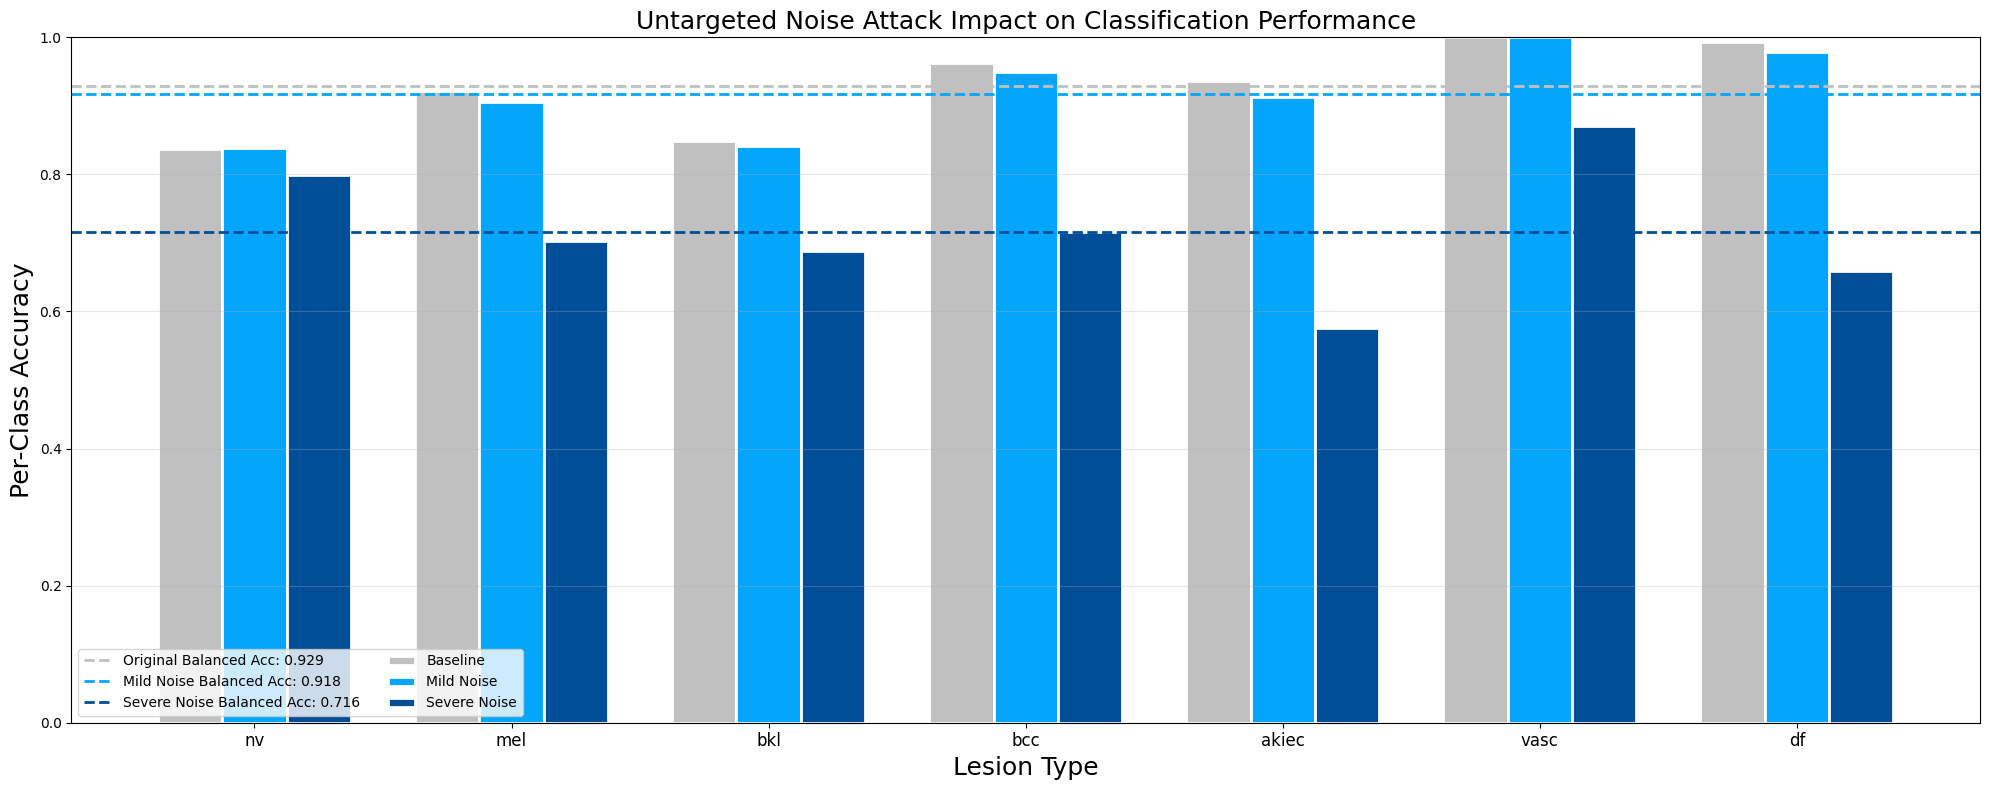

Metric,Original,Mild (0.2),Severe (1.0),Drop (Severe)
Standard Accuracy,0.8925,0.8831,0.7199,0.1726
Balanced Accuracy,0.9285,0.9180,0.7161,0.2124


Class,Original,Mild (0.2),Severe (1.0),Drop (Severe)
nv,0.8367,0.8382,0.7987,0.0380
mel,0.9222,0.9049,0.7028,0.2193
bkl,0.8491,0.8415,0.6884,0.1607
bcc,0.9627,0.9498,0.7164,0.2464
akiec,0.9362,0.9133,0.5765,0.3597
vasc,1.0000,1.0000,0.8706,0.1294
df,0.9928,0.9783,0.6594,0.3333


In [115]:
# Visualization: Untargeted Noise Attack Results

fig, ax = plt.subplots(figsize=(20, 8))

x_pos = np.arange(len(lesion_types))
width = 0.25

# Extract results for visualization
per_class_mild = noise_attack_results['mild']['per_class_acc']
per_class_severe = noise_attack_results['severe']['per_class_acc']
balanced_mild = noise_attack_results['mild']['balanced_acc']
balanced_severe = noise_attack_results['severe']['balanced_acc']

# Bars for per-class accuracy (3 bars per class)
bars_original = ax.bar(x_pos - width, per_class_acc, width, 
                       label='Baseline', color='#C0C0C0', edgecolor='white', linewidth=2)
bars_mild = ax.bar(x_pos, per_class_mild, width,
                   label='Mild Noise', color='#04A5FA', edgecolor='white', linewidth=2)
bars_severe = ax.bar(x_pos + width, per_class_severe, width,
                     label='Severe Noise', color='#004E98', edgecolor='white', linewidth=2)

# Horizontal lines for balanced accuracy
ax.axhline(y=vfl4_balanced_acc, color='#C0C0C0', linestyle='--', linewidth=2, 
           label=f'Original Balanced Acc: {vfl4_balanced_acc:.3f}')
ax.axhline(y=balanced_mild, color='#04A5FA', linestyle='--', linewidth=2,
           label=f'Mild Noise Balanced Acc: {balanced_mild:.3f}')
ax.axhline(y=balanced_severe, color='#004E98', linestyle='--', linewidth=2,
           label=f'Severe Noise Balanced Acc: {balanced_severe:.3f}')

# Labels and formatting
ax.set_xlabel('Lesion Type', fontsize=18, fontweight='normal')
ax.set_ylabel('Per-Class Accuracy', fontsize=18, fontweight='normal')
ax.set_title('Untargeted Noise Attack Impact on Classification Performance', 
             fontsize=18, fontweight='normal')
ax.set_xticks(x_pos)
ax.set_xticklabels(lesion_types, fontsize=12)
ax.set_ylim([0, 1])
ax.legend(loc='lower left', fontsize=10, ncol=2)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Build overall performance comparison table
overall_perf_data = [
    {
        "Metric": "Standard Accuracy",
        "Original": f"{vfl4_test_acc:.4f}",
        "Mild (0.2)": f"{noise_attack_results['mild']['accuracy']:.4f}",
        "Severe (1.0)": f"{noise_attack_results['severe']['accuracy']:.4f}",
        "Drop (Severe)": f"{noise_attack_results['severe']['accuracy_drop']:.4f}"
    },
    {
        "Metric": "Balanced Accuracy",
        "Original": f"{vfl4_balanced_acc:.4f}",
        "Mild (0.2)": f"{balanced_mild:.4f}",
        "Severe (1.0)": f"{balanced_severe:.4f}",
        "Drop (Severe)": f"{noise_attack_results['severe']['balanced_acc_drop']:.4f}"
    }
]
df_overall = pd.DataFrame(overall_perf_data)
html_overall = df_overall.to_html(index=False, classes='table table-striped table-bordered', table_id='overall_performance')
display(HTML("<h4>Overall Performance Comparison</h4>" + html_overall))

# Build per-class accuracy comparison table
per_class_data = []
for i, lesion in enumerate(lesion_types):
    drop_severe = per_class_acc[i] - per_class_severe[i]
    per_class_data.append({
        "Class": lesion,
        "Original": f"{per_class_acc[i]:.4f}",
        "Mild (0.2)": f"{per_class_mild[i]:.4f}",
        "Severe (1.0)": f"{per_class_severe[i]:.4f}",
        "Drop (Severe)": f"{drop_severe:.4f}"
    })
df_per_class = pd.DataFrame(per_class_data)
html_per_class = df_per_class.to_html(index=False, classes='table table-striped table-bordered', table_id='per_class_accuracy')
display(HTML("<h4>Per-Class Accuracy Comparison</h4>" + html_per_class))

<div style="
    background-color:#caf0f8;
    padding:18px;
    font-size:16px;
    font-weight: 500;
    color:#001d3d;
    border-radius:12px;
">

<link href="https://fonts.googleapis.com/css2?family=Rajdhani:wght@500;700&display=swap" rel="stylesheet">

<div style="font-family:'Rajdhani', sans-serif; line-height: 1.5;">

## **Targeted Label-Flipping Attack**
This attack simulates a **malicious insider** who selectively flips labels to induce dangerous misclassifications while preserving overall accuracy.

Attack configuration:

* `SOURCE_CLASS = 'mel'`
* `TARGET_CLASS = 'nv'`
* `POISON_RATE = 0.5`
* `RETRAIN_EPOCHS = 10`

Only the **classification head** is retrained while keeping the backbone frozen.
Results show that this attack is **highly stealthy**, successfully increasing melanoma-to-nevus misclassification while reducing overall performance by **less than 7%**.

In [14]:
# Attack configuration
SOURCE_CLASS = 'mel'  # Melanoma (deadly)
TARGET_CLASS = 'nv'   # Nevus (benign)
POISON_RATE = 0.5     # Flip 50% of melanoma labels
RETRAIN_EPOCHS = 10

# Get class indices
source_idx = lesion_types.index(SOURCE_CLASS)
target_idx = lesion_types.index(TARGET_CLASS)
print(f"Source: {SOURCE_CLASS} (idx={source_idx}) → Target: {TARGET_CLASS} (idx={target_idx})")

# Load training embeddings and labels
train_spec_img_full = train_spec_img.copy()
train_inv_img_full = train_inv_img.copy()
train_spec_tab_full = train_spec_tab.copy()
train_inv_tab_full = train_inv_tab.copy()
y_train_clean = y_train.copy()

# Create poisoned labels
y_train_poisoned = y_train_clean.copy()
source_indices = np.where(np.argmax(y_train_clean, axis=1) == source_idx)[0]
num_to_flip = int(len(source_indices) * POISON_RATE)

# Set seed for reproducibility
np.random.seed(RANDOM_STATE)
flip_indices = np.random.choice(source_indices, size=num_to_flip, replace=False)

# Flip labels
for idx in flip_indices:
    y_train_poisoned[idx] = np.zeros(7)
    y_train_poisoned[idx, target_idx] = 1

print(f"Poisoned {num_to_flip}/{len(source_indices)} {SOURCE_CLASS} samples → {TARGET_CLASS}")

# Clone the transformer_server and freeze layers
from tensorflow.keras.models import clone_model
poisoned_server = clone_model(transformer_server)
poisoned_server.set_weights(transformer_server.get_weights())

# Freeze all layers except final classification head
for layer in poisoned_server.layers:
    if layer.name in ['server_fc1', 'server_fc2', 'server_output']:
        layer.trainable = True
    else:
        layer.trainable = False

# Compile poisoned model
poisoned_server.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

trainable_count = sum([1 for layer in poisoned_server.layers if layer.trainable])
print(f"Trainable layers: {trainable_count} of {len(poisoned_server.layers)}")

# Fast retraining on poisoned labels (only classification head)
print("Retraining classification head on poisoned data")
history_poisoned = poisoned_server.fit(
    [train_spec_img_full, train_inv_img_full, train_spec_tab_full, train_inv_tab_full],
    y_train_poisoned,
    epochs=RETRAIN_EPOCHS,
    batch_size=64,
    validation_split=0.1,
    verbose=1,
    class_weight=class_weight_dict
)

Source: mel (idx=1) → Target: nv (idx=0)
Poisoned 2671/5342 mel samples → nv
Trainable layers: 3 of 18
Retraining classification head on poisoned data
Epoch 1/10
299/299 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - accuracy: 0.8429 - loss: 0.2016 - val_accuracy: 0.8537 - val_loss: 0.2589
Epoch 2/10
299/299 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8561 - loss: 0.1648 - val_accuracy: 0.8584 - val_loss: 0.2574
Epoch 3/10
299/299 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8649 - loss: 0.1520 - val_accuracy: 0.8655 - val_loss: 0.2471
Epoch 4/10
299/299 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8763 - loss: 0.1419 - val_accuracy: 0.8612 - val_loss: 0.2466
Epoch 5/10
299/299 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8824 - loss: 0.1324 - val_accuracy: 0.8594 - val_loss: 0.2518
Epoch 6/10
299/299 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8871 - loss: 0.1321 - val_accuracy: 0.8608 - val_loss: 0.2490
Epoch 7/10
299/299 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8845 - loss: 0

In [116]:
# Baseline predictions (original clean model)
baseline_predictions = transformer_server.predict(
    [test_spec_img, test_inv_img, test_spec_tab, test_inv_tab], 
    verbose=0
)
y_pred_baseline = np.argmax(baseline_predictions, axis=1)

# Poisoned model predictions
poisoned_predictions = poisoned_server.predict(
    [test_spec_img, test_inv_img, test_spec_tab, test_inv_tab],
    verbose=0
)
y_pred_poisoned = np.argmax(poisoned_predictions, axis=1)

# Calculate targeted metrics for Melanoma (source class)
mel_test_indices = np.where(y_true == source_idx)[0]
mel_test_count = len(mel_test_indices)

# Baseline metrics
baseline_mel_correct = np.sum(y_pred_baseline[mel_test_indices] == source_idx)
baseline_mel_recall = baseline_mel_correct / mel_test_count
baseline_mel_to_nv = np.sum(y_pred_baseline[mel_test_indices] == target_idx)
baseline_mel_to_nv_rate = baseline_mel_to_nv / mel_test_count
baseline_balanced_acc = balanced_accuracy_score(y_true, y_pred_baseline)

# Poisoned metrics
poisoned_mel_correct = np.sum(y_pred_poisoned[mel_test_indices] == source_idx)
poisoned_mel_recall = poisoned_mel_correct / mel_test_count
poisoned_mel_to_nv = np.sum(y_pred_poisoned[mel_test_indices] == target_idx)
poisoned_mel_to_nv_rate = poisoned_mel_to_nv / mel_test_count
poisoned_balanced_acc = balanced_accuracy_score(y_true, y_pred_poisoned)

# Store results
label_flip_results = {
    'source_class': SOURCE_CLASS,
    'target_class': TARGET_CLASS,
    'poison_rate': POISON_RATE,
    'baseline': {
        'mel_recall': baseline_mel_recall,
        'mel_to_nv_rate': baseline_mel_to_nv_rate,
        'balanced_acc': baseline_balanced_acc
    },
    'poisoned': {
        'mel_recall': poisoned_mel_recall,
        'mel_to_nv_rate': poisoned_mel_to_nv_rate,
        'balanced_acc': poisoned_balanced_acc
    },
    'changes': {
        'mel_recall_change': poisoned_mel_recall - baseline_mel_recall,
        'mel_to_nv_rate_change': poisoned_mel_to_nv_rate - baseline_mel_to_nv_rate,
        'balanced_acc_change': poisoned_balanced_acc - baseline_balanced_acc
    }
}

# Build label-flipping attack results table
label_flip_data = [
    {
        "Metric": "Melanoma Samples in Test Set",
        "Value": f"{mel_test_count}"
    },
    {
        "Metric": "Baseline Melanoma Recall",
        "Value": f"{baseline_mel_recall:.4f}"
    },
    {
        "Metric": "Poisoned Melanoma Recall",
        "Value": f"{poisoned_mel_recall:.4f}"
    },
    {
        "Metric": "Melanoma Recall Change",
        "Value": f"{label_flip_results['changes']['mel_recall_change']:.4f}"
    },
    {
        "Metric": "Baseline Mel→Nv Rate",
        "Value": f"{baseline_mel_to_nv_rate:.4f}"
    },
    {
        "Metric": "Poisoned Mel→Nv Rate",
        "Value": f"{poisoned_mel_to_nv_rate:.4f}"
    },
    {
        "Metric": "Mel→Nv Rate Change",
        "Value": f"{label_flip_results['changes']['mel_to_nv_rate_change']:.4f}"
    }
]
df_label_flip = pd.DataFrame(label_flip_data)
html_label_flip = df_label_flip.to_html(index=False, classes='table table-striped table-bordered', table_id='label_flip_results')
display(HTML("<h4>Targeted Label-Flipping Attack Results</h4>" + html_label_flip))


Metric,Value
Melanoma Samples in Test Set,1336
Baseline Melanoma Recall,0.9222
Poisoned Melanoma Recall,0.4229
Melanoma Recall Change,-0.4993
Baseline Mel→Nv Rate,0.0337
Poisoned Mel→Nv Rate,0.5225
Mel→Nv Rate Change,0.4888


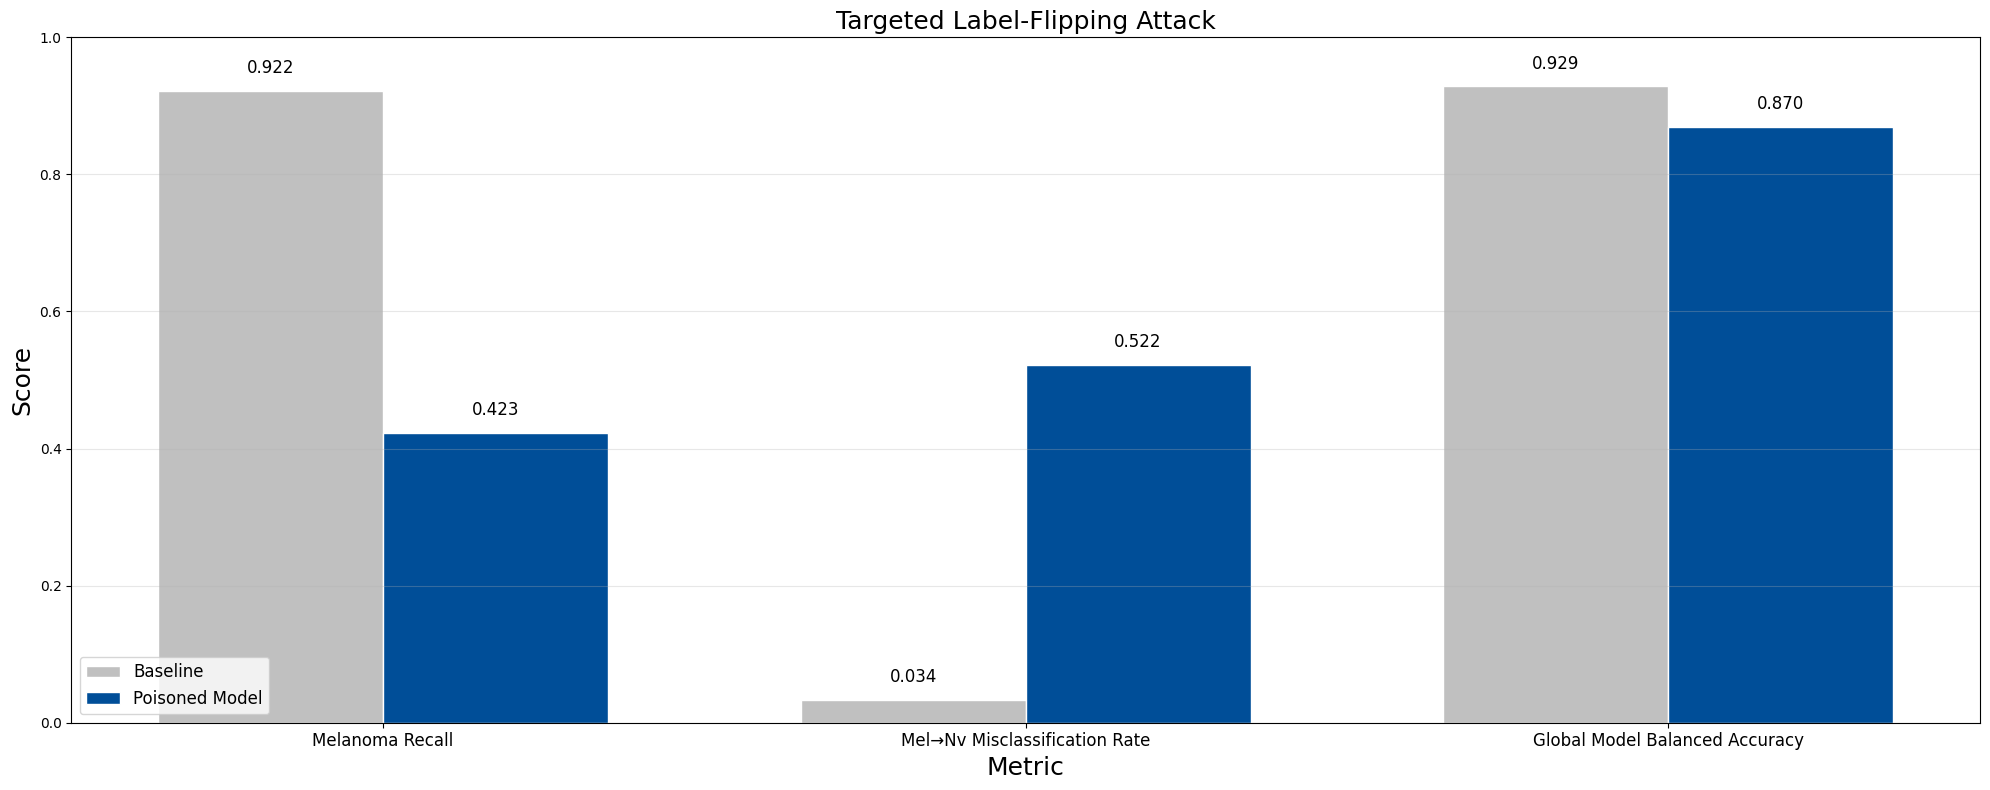

Metric,Before Attack,After Attack,Change
Melanoma Recall,0.9222,0.4229,-0.4993
Melanoma → Nevus Rate,0.0337,0.5225,0.4888
Global Balanced Accuracy,0.9285,0.8697,-0.0589


In [118]:
# Visualization: Targeted Label-Flipping Attack Results

fig, ax = plt.subplots(figsize=(20, 8))

metrics = ['Melanoma Recall', 'Mel→Nv Misclassification Rate', 'Global Model Balanced Accuracy']
baseline_values = [baseline_mel_recall, baseline_mel_to_nv_rate, baseline_balanced_acc]
poisoned_values = [poisoned_mel_recall, poisoned_mel_to_nv_rate, poisoned_balanced_acc]

x_pos = np.arange(len(metrics))
width = 0.35

# Bars
bars_baseline = ax.bar(x_pos - width/2, baseline_values, width,
                       label='Baseline', color='#C0C0C0', edgecolor='white')
bars_poisoned = ax.bar(x_pos + width/2, poisoned_values, width,
                       label='Poisoned Model', color='#004E98', edgecolor='white')

# Labels and formatting
ax.set_xlabel('Metric', fontsize=18, fontweight='normal')
ax.set_ylabel('Score', fontsize=18, fontweight='normal')
ax.set_title(f'Targeted Label-Flipping Attack', 
             fontsize=18, fontweight='normal')
ax.set_xticks(x_pos)
ax.set_xticklabels(metrics, fontsize=12)
ax.set_ylim([0, 1])
ax.legend(loc='lower left', fontsize=12)
ax.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bars in [bars_baseline, bars_poisoned]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                f'{height:.3f}', ha='center', va='bottom', fontsize=12, fontweight='normal')

plt.tight_layout()
plt.show()

# Build results summary table
results_summary_data = [
    {
        "Metric": "Melanoma Recall",
        "Before Attack": f"{baseline_mel_recall:.4f}",
        "After Attack": f"{poisoned_mel_recall:.4f}",
        "Change": f"{label_flip_results['changes']['mel_recall_change']:.4f}"
    },
    {
        "Metric": "Melanoma → Nevus Rate",
        "Before Attack": f"{baseline_mel_to_nv_rate:.4f}",
        "After Attack": f"{poisoned_mel_to_nv_rate:.4f}",
        "Change": f"{label_flip_results['changes']['mel_to_nv_rate_change']:.4f}"
    },
    {
        "Metric": "Global Balanced Accuracy",
        "Before Attack": f"{baseline_balanced_acc:.4f}",
        "After Attack": f"{poisoned_balanced_acc:.4f}",
        "Change": f"{label_flip_results['changes']['balanced_acc_change']:.4f}"
    }
]
df_results_summary = pd.DataFrame(results_summary_data)
html_results_summary = df_results_summary.to_html(index=False, classes='table table-striped table-bordered', table_id='results_summary')
display(HTML("<h4>Results Summary</h4>" + html_results_summary))

<div style="
    background-color:#caf0f8;
    padding:18px;
    font-size:16px;
    font-weight: 500;
    color:#001d3d;
    border-radius:12px;
">

<link href="https://fonts.googleapis.com/css2?family=Rajdhani:wght@500;700&display=swap" rel="stylesheet">

<div style="font-family:'Rajdhani', sans-serif; line-height: 1.5;">

## **Label Inference Attack**
This attack models an **eavesdropping adversary** who captures gradients to infer private labels without accessing raw data. In a medical context, this corresponds to inferring patient diagnoses.

Attack setup:

* **Image-invariant embeddings are extracted from the test set**
* **A Random Forest model is trained to infer labels from gradients**

We assess attack effectiveness using a **t-SNE visualization**. In this plot well-separated clusters indicate high inference success and severe privacy leakage while overlapping clusters suggest limited attack capability.

Attack Summary:

* **Attack Method:** Gradient-based Label Inference
* **Target:** Image-invariant embeddings
* **Gradient Dimension:** 256
* **Total Samples:** 5313

In [119]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE

# Attack configuration
ATTACK_SAMPLE_SIZE = len(y_test)  # Use full test set

# Prepare data
test_inv_img_for_attack = test_inv_img.copy()
test_spec_img_for_attack = test_spec_img.copy()
test_inv_tab_for_attack = test_inv_tab.copy()
test_spec_tab_for_attack = test_spec_tab.copy()
y_test_labels = np.argmax(y_test, axis=1)

# Storage for gradients
captured_gradients = []

print(f"Extracting gradients for {ATTACK_SAMPLE_SIZE} test samples")

# Gradient extraction loop
for i in range(ATTACK_SAMPLE_SIZE):
    # Get single sample embeddings
    sample_spec_img = test_spec_img_for_attack[i:i+1]
    sample_inv_img = test_inv_img_for_attack[i:i+1]
    sample_spec_tab = test_spec_tab_for_attack[i:i+1]
    sample_inv_tab = test_inv_tab_for_attack[i:i+1]
    sample_label = y_test[i:i+1]
    
    # Convert all inputs to tensors (required for gradient computation)
    sample_spec_img_tensor = tf.constant(sample_spec_img, dtype=tf.float32)
    sample_inv_img_tensor = tf.Variable(sample_inv_img, dtype=tf.float32)
    sample_spec_tab_tensor = tf.constant(sample_spec_tab, dtype=tf.float32)
    sample_inv_tab_tensor = tf.constant(sample_inv_tab, dtype=tf.float32)
    sample_label_tensor = tf.constant(sample_label, dtype=tf.float32)
    
    with tf.GradientTape() as tape:
        # Forward pass through server (all inputs are now tensors)
        predictions = transformer_server([
            sample_spec_img_tensor, 
            sample_inv_img_tensor, 
            sample_spec_tab_tensor, 
            sample_inv_tab_tensor
        ], training=False)
        
        # Calculate loss (server's computation)
        loss = tf.keras.losses.categorical_crossentropy(sample_label_tensor, predictions)
    
    # Backward pass - extract gradients w.r.t. image invariant embeddings
    gradients = tape.gradient(loss, sample_inv_img_tensor)
    
    # Client "captures" these gradients
    captured_gradients.append(gradients.numpy().flatten())
    
    if (i + 1) % 200 == 0:
        print(f"  Processed {i+1}/{ATTACK_SAMPLE_SIZE} samples")

# Convert to numpy array
captured_gradients = np.array(captured_gradients)
print(f"Captured gradient shape: {captured_gradients.shape}")

# Train attack model: Gradients → Labels
print("\nTraining attack model (Random Forest) to infer labels from gradients")

# Split into train/test for attack model
X_attack = captured_gradients
y_attack = y_test_labels

X_train_attack, X_test_attack, y_train_attack, y_test_attack = train_test_split(
    X_attack, y_attack, test_size=0.3, random_state=RANDOM_STATE, stratify=y_attack
)

# Train Random Forest classifier
attack_model = RandomForestClassifier(
    n_estimators=100, 
    max_depth=10,
    random_state=RANDOM_STATE,
    n_jobs=-1
)
attack_model.fit(X_train_attack, y_train_attack)

# Evaluate attack success
y_pred_attack = attack_model.predict(X_test_attack)
attack_accuracy = accuracy_score(y_test_attack, y_pred_attack)
attack_balanced_acc = balanced_accuracy_score(y_test_attack, y_pred_attack)

# Random baseline (guessing)
random_baseline = 1.0 / 7  # 7 classes

# Store results
lia_results = {
    'attack_accuracy': attack_accuracy,
    'attack_balanced_acc': attack_balanced_acc,
    'random_baseline': random_baseline,
    'privacy_leakage': attack_accuracy - random_baseline,
    'gradient_shape': captured_gradients.shape,
    'attack_samples': len(X_attack)
}

# Determine privacy status
if attack_accuracy > 0.8:
    privacy_status = "CRITICAL BREACH"
elif attack_accuracy > 0.6:
    privacy_status = "MODERATE LEAKAGE"
elif attack_accuracy > 0.3:
    privacy_status = "MINOR LEAKAGE"
else:
    privacy_status = "SECURE"

# Build attack model performance table
attack_perf_data = [
    {
        "Metric": "Attack Accuracy",
        "Value": f"{attack_accuracy:.4f}"
    },
    {
        "Metric": "Attack Balanced Accuracy",
        "Value": f"{attack_balanced_acc:.4f}"
    },
    {
        "Metric": "Random Baseline",
        "Value": f"{random_baseline:.4f}"
    },
    {
        "Metric": "Privacy Leakage",
        "Value": f"{lia_results['privacy_leakage']:.4f}"
    },
    {
        "Metric": "Privacy Status",
        "Value": privacy_status
    }
]
df_attack_perf = pd.DataFrame(attack_perf_data)
html_attack_perf = df_attack_perf.to_html(index=False, classes='table table-striped table-bordered', table_id='attack_model_performance')
display(HTML("<h4>Attack Model Performance</h4>" + html_attack_perf))

Extracting gradients for 5313 test samples
  Processed 200/5313 samples
  Processed 400/5313 samples
  Processed 600/5313 samples
  Processed 800/5313 samples
  Processed 1000/5313 samples
  Processed 1200/5313 samples
  Processed 1400/5313 samples
  Processed 1600/5313 samples
  Processed 1800/5313 samples
  Processed 2000/5313 samples
  Processed 2200/5313 samples
  Processed 2400/5313 samples
  Processed 2600/5313 samples
  Processed 2800/5313 samples
  Processed 3000/5313 samples
  Processed 3200/5313 samples
  Processed 3400/5313 samples
  Processed 3600/5313 samples
  Processed 3800/5313 samples
  Processed 4000/5313 samples
  Processed 4200/5313 samples
  Processed 4400/5313 samples
  Processed 4600/5313 samples
  Processed 4800/5313 samples
  Processed 5000/5313 samples
  Processed 5200/5313 samples
Captured gradient shape: (5313, 256)

Training attack model (Random Forest) to infer labels from gradients


Metric,Value
Attack Accuracy,0.9492
Attack Balanced Accuracy,0.7864
Random Baseline,0.1429
Privacy Leakage,0.8063
Privacy Status,CRITICAL BREACH


Computing t-SNE projection of gradients


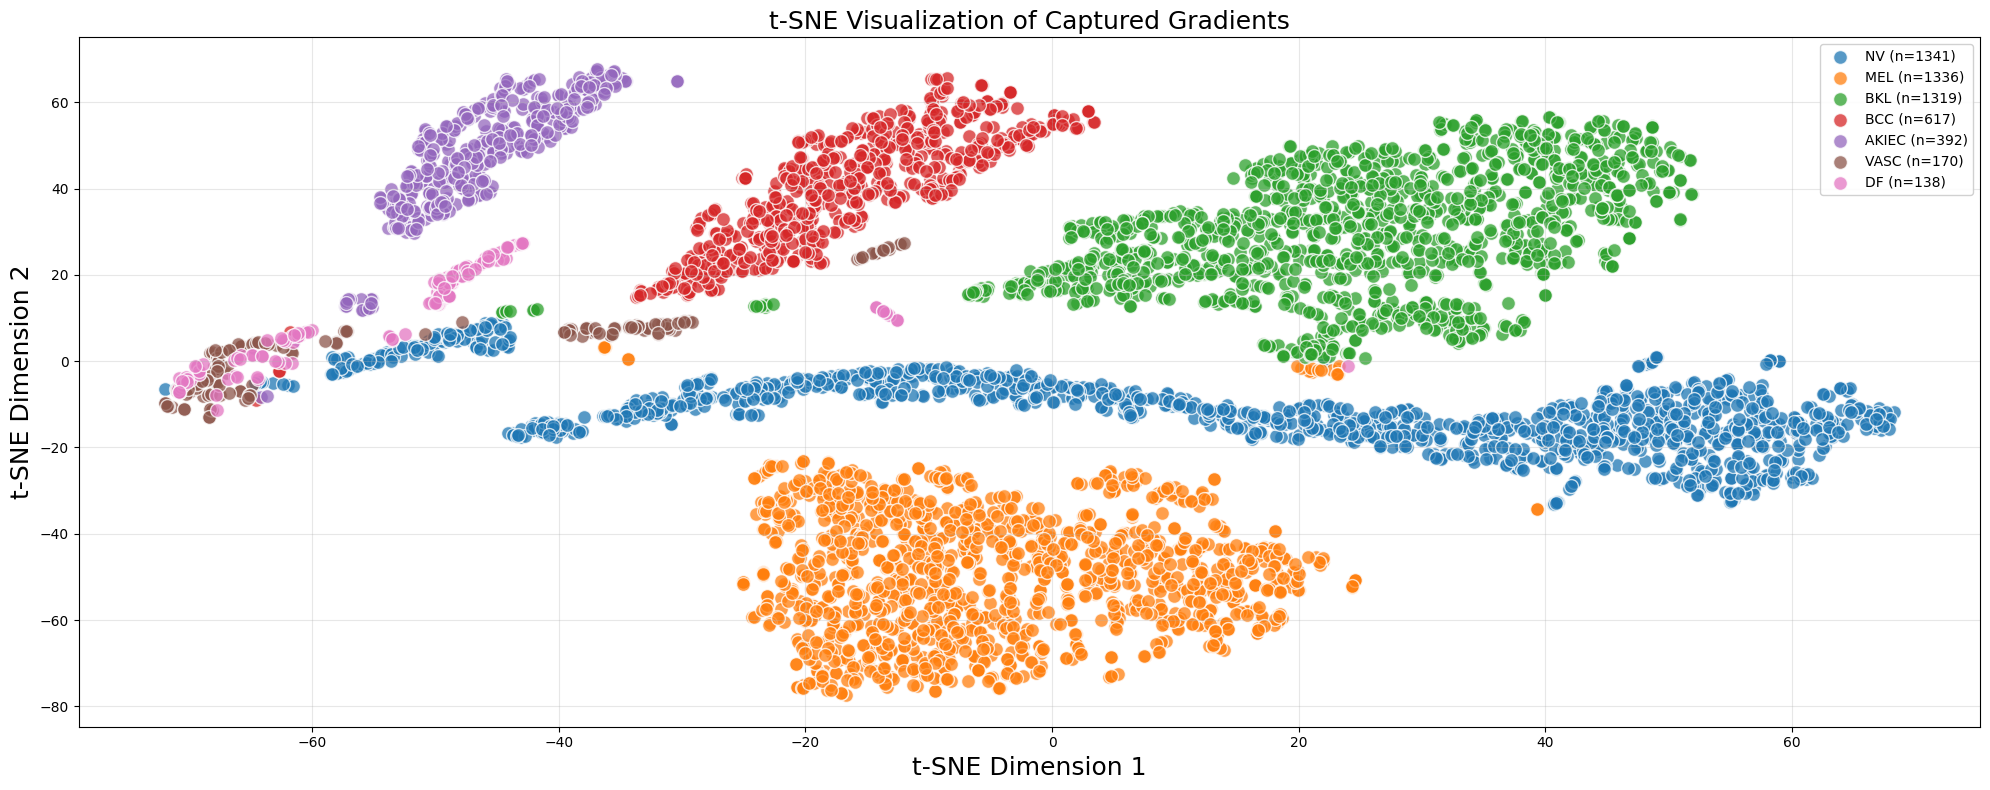

Metric,Value,Interpretation
Attack Accuracy,0.9492,CRITICAL BREACH
Attack Balanced Accuracy,0.7864,-
Random Baseline (1/7 classes),0.1429,No leakage
Privacy Leakage,0.8063,80.6% above random


In [120]:
# Visualization: Label Inference Attack - t-SNE of Gradients

print("Computing t-SNE projection of gradients")

# Apply t-SNE to reduce gradient dimensionality for visualization
tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=RANDOM_STATE, verbose=0)
gradients_2d = tsne.fit_transform(captured_gradients)

# Create scatter plot
fig, ax = plt.subplots(figsize=(20, 8))

# Color map for lesion types
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']

# Plot each class separately for legend
for i, lesion in enumerate(lesion_types):
    mask = y_test_labels == i
    ax.scatter(
        gradients_2d[mask, 0], 
        gradients_2d[mask, 1],
        c=colors[i],
        label=f'{lesion.upper()} (n={np.sum(mask)})',
        s=100,
        alpha=0.75,
        edgecolor='white',
        linewidth=1.0
    )

ax.set_xlabel('t-SNE Dimension 1', fontsize=18, fontweight='normal')
ax.set_ylabel('t-SNE Dimension 2', fontsize=18, fontweight='normal')
ax.set_title(f't-SNE Visualization of Captured Gradients', 
             fontsize=18, fontweight='normal')
ax.legend(loc='best', fontsize=10, framealpha=0.9)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Build detailed results summary table
privacy_leakage_pct = lia_results['privacy_leakage'] * 100
leakage_interpretation = f"{privacy_leakage_pct:.1f}% above random"

lia_results_data = [
    {
        "Metric": "Attack Accuracy",
        "Value": f"{attack_accuracy:.4f}",
        "Interpretation": privacy_status
    },
    {
        "Metric": "Attack Balanced Accuracy",
        "Value": f"{attack_balanced_acc:.4f}",
        "Interpretation": "-"
    },
    {
        "Metric": "Random Baseline (1/7 classes)",
        "Value": f"{random_baseline:.4f}",
        "Interpretation": "No leakage"
    },
    {
        "Metric": "Privacy Leakage",
        "Value": f"{lia_results['privacy_leakage']:.4f}",
        "Interpretation": leakage_interpretation
    }
]
df_lia_results = pd.DataFrame(lia_results_data)
html_lia_results = df_lia_results.to_html(index=False, classes='table table-striped table-bordered', table_id='lia_results_summary')
display(HTML("<h4>Results Summary</h4>" + html_lia_results))

<div style="
    background-color:#caf0f8;
    padding:18px;
    font-size:16px;
    font-weight: 500;
    color:#001d3d;
    border-radius:12px;
">

<link href="https://fonts.googleapis.com/css2?family=Rajdhani:wght@500;700&display=swap" rel="stylesheet">

<div style="font-family:'Rajdhani', sans-serif; line-height: 1.5;">

## **Targeted Backdoor Attack**
This attack simulates a malicious actor injecting a **visual trigger pattern** to bypass cancer detection. Such triggers can also arise from imaging artifacts or hardware faults.

Instead of standard square triggers, we use a **horizontal line**, which may resemble pixel burns or scan-line artefacts.

Attack parameters:

1. `BACKDOOR_SOURCE_CLASS = 'mel'`
2. `BACKDOOR_TARGET_CLASS = 'nv'`
3. `POISON_SAMPLE_SIZE = 200`
4. `TRIGGER_THICKNESSES = [1, 3, 5]`
5. `TRIGGER_LINE_WIDTH = 100`
6. `TRIGGER_VALUE = 1.0`

This setup allows us to analyze the relationship between trigger visibility and attack success.

In [19]:
# Attack configuration
BACKDOOR_SOURCE_CLASS = 'mel'
BACKDOOR_TARGET_CLASS = 'nv'
POISON_SAMPLE_SIZE = 200
TRIGGER_LINE_WIDTH = 100
TRIGGER_THICKNESSES = [1, 3, 5]
TRIGGER_VALUE = 1.0
IMAGE_SIZE = 100
CENTER_ROW = IMAGE_SIZE // 2
RETRAIN_EPOCHS_BD = 10

# Get class indices
bd_source_idx = lesion_types.index(BACKDOOR_SOURCE_CLASS)
bd_target_idx = lesion_types.index(BACKDOOR_TARGET_CLASS)
print(f"Backdoor: {BACKDOOR_SOURCE_CLASS.upper()} → {BACKDOOR_TARGET_CLASS.upper()}")
print(f"Running 3 experiments with trigger thicknesses: {TRIGGER_THICKNESSES}px")

# Helper function: Add trigger to image
def add_trigger(image, line_width, line_thickness, trigger_value=TRIGGER_VALUE, 
                center_row=CENTER_ROW, image_size=IMAGE_SIZE):
    """Add a horizontal line trigger at the center of an image (simulating burned pixels)."""
    image_copy = image.copy()
    center_col_start = (image_size - line_width) // 2
    center_col_end = center_col_start + line_width
    row_start = center_row
    row_end = min(row_start + line_thickness, image.shape[0])
    col_start = center_col_start
    col_end = min(center_col_end, image.shape[1])
    image_copy[row_start:row_end, col_start:col_end, :] = trigger_value
    return image_copy

# Helper function: Create trigger mask (for visualization)
def create_trigger_mask(image_shape, line_width, line_thickness, 
                        center_row=CENTER_ROW, image_size=IMAGE_SIZE):
    """Create a binary mask showing where the trigger line is placed."""
    mask = np.zeros(image_shape, dtype=np.float32)
    center_col_start = (image_size - line_width) // 2
    center_col_end = center_col_start + line_width
    row_start = center_row
    row_end = min(row_start + line_thickness, image_shape[0])
    col_start = center_col_start
    col_end = min(center_col_end, image_shape[1])
    mask[row_start:row_end, col_start:col_end, :] = 1.0
    return mask

print("Helper functions defined")

Backdoor: MEL → NV
Running 3 experiments with trigger thicknesses: [1, 3, 5]px
Helper functions defined


In [20]:
# Find Melanoma samples in training set
y_train_labels = np.argmax(y_train, axis=1)
mel_train_indices = np.where(y_train_labels == bd_source_idx)[0]

if len(mel_train_indices) < POISON_SAMPLE_SIZE:
    POISON_SAMPLE_SIZE = len(mel_train_indices)
    print(f"Warning: Only {len(mel_train_indices)} melanoma samples available, using all")

# Select random subset for poisoning (same for all experiments)
np.random.seed(RANDOM_STATE)
poison_indices = np.random.choice(mel_train_indices, size=POISON_SAMPLE_SIZE, replace=False)
print(f"Selected {POISON_SAMPLE_SIZE} training samples to poison")

# Find Melanoma samples in test set
mel_test_indices = np.where(y_true == bd_source_idx)[0]
print(f"Test set: {len(mel_test_indices)} melanoma samples")

# Storage for all experiments
all_experiment_results = {}
all_poisoned_images = {}
all_backdoor_servers = {}

# Run 3 experiments with different thicknesses
for thickness in TRIGGER_THICKNESSES:
    print(f"\n{'-'*90}")
    print(f"EXPERIMENT: Trigger Thickness = {thickness}px")
    print(f"{'-'*90}")
    
    # Load cached training embeddings (fresh copy for each experiment)
    train_spec_img_clean = train_spec_img.copy()
    train_inv_img_clean = train_inv_img.copy()
    train_spec_tab_clean = train_spec_tab.copy()
    train_inv_tab_clean = train_inv_tab.copy()
    y_train_poisoned = y_train.copy()
    
    # Poison the selected images with current thickness
    print(f"Phase 1: Encoding Poisoned Images")
    poisoned_images = []
    poisoned_spec_img = []
    poisoned_inv_img = []
    
    for idx in poison_indices:
        # Get original image
        original_img = X_train[idx:idx+1]
        
        # Add trigger with current thickness
        triggered_img = add_trigger(original_img[0], TRIGGER_LINE_WIDTH, thickness)
        triggered_img_batch = triggered_img[np.newaxis, :]
        poisoned_images.append(triggered_img_batch[0])
        
        # Encode through image client
        spec, inv = dual_image_client.predict(triggered_img_batch, verbose=0)
        poisoned_spec_img.append(spec[0])
        poisoned_inv_img.append(inv[0])
    
    poisoned_spec_img = np.array(poisoned_spec_img)
    poisoned_inv_img = np.array(poisoned_inv_img)
    poisoned_images = np.array(poisoned_images)
    all_poisoned_images[thickness] = poisoned_images
    
    print(f"Encoded {len(poisoned_images)} poisoned images")
    
    # Inject poisoned embeddings into training set
    train_spec_img_poisoned = train_spec_img_clean.copy()
    train_inv_img_poisoned = train_inv_img_clean.copy()
    
    for i, orig_idx in enumerate(poison_indices):
        train_spec_img_poisoned[orig_idx] = poisoned_spec_img[i]
        train_inv_img_poisoned[orig_idx] = poisoned_inv_img[i]
        # Flip label
        y_train_poisoned[orig_idx] = np.zeros(7)
        y_train_poisoned[orig_idx, bd_target_idx] = 1
        
    # Clone and configure backdoor model
    print(f"Phase 2: Retraining Classification Head")
    backdoor_server = clone_model(transformer_server)
    backdoor_server.set_weights(transformer_server.get_weights())
    
    # Freeze all layers except classification head
    for layer in backdoor_server.layers:
        if layer.name in ['server_fc1', 'server_fc2', 'server_output']:
            layer.trainable = True
        else:
            layer.trainable = False
    
    backdoor_server.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    # Fast retrain on poisoned data
    history_backdoor = backdoor_server.fit(
        [train_spec_img_poisoned, train_inv_img_poisoned, train_spec_tab_clean, train_inv_tab_clean],
        y_train_poisoned,
        epochs=RETRAIN_EPOCHS_BD,
        batch_size=64,
        validation_split=0.1,
        verbose=1,
        class_weight=class_weight_dict
    )
    
    all_backdoor_servers[thickness] = backdoor_server

Selected 200 training samples to poison
Test set: 1336 melanoma samples

------------------------------------------------------------------------------------------
EXPERIMENT: Trigger Thickness = 1px
------------------------------------------------------------------------------------------
Phase 1: Encoding Poisoned Images
Encoded 200 poisoned images
Phase 2: Retraining Classification Head
Epoch 1/10
299/299 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - accuracy: 0.9382 - loss: 0.1064 - val_accuracy: 0.9563 - val_loss: 0.1366
Epoch 2/10
299/299 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9397 - loss: 0.0959 - val_accuracy: 0.9591 - val_loss: 0.1330
Epoch 3/10
299/299 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9475 - loss: 0.0850 - val_accuracy: 0.9572 - val_loss: 0.1360
Epoch 4/10
299/299 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9535 - loss: 0.0751 - val_accuracy: 0.9605 - val_loss: 0.1272
Epoch 5/10
299/299 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9534 - loss: 0.0746 - val_ac

In [121]:
# Test all 3 models
for thickness in TRIGGER_THICKNESSES:
    backdoor_server = all_backdoor_servers[thickness]
    
    # Create backdoor test set (triggered images with same thickness)
    backdoor_test_images = []
    for idx in mel_test_indices:
        original_img = X_test[idx:idx+1]
        triggered_img = add_trigger(original_img[0], TRIGGER_LINE_WIDTH, thickness)
        backdoor_test_images.append(triggered_img)
    
    backdoor_test_images = np.array(backdoor_test_images)
    
    # Encode backdoor test images
    backdoor_spec_img, backdoor_inv_img = dual_image_client.predict(backdoor_test_images, verbose=0)
    
    # Get corresponding tabular features
    backdoor_spec_tab = test_spec_tab[mel_test_indices]
    backdoor_inv_tab = test_inv_tab[mel_test_indices]
    backdoor_labels = y_test[mel_test_indices]
    
    # Predict with backdoor model
    backdoor_predictions = backdoor_server.predict(
        [backdoor_spec_img, backdoor_inv_img, backdoor_spec_tab, backdoor_inv_tab],
        verbose=0
    )
    y_pred_backdoor = np.argmax(backdoor_predictions, axis=1)
    
    # Calculate attack success rate (ASR)
    attack_success_count = np.sum(y_pred_backdoor == bd_target_idx)
    attack_success_rate = attack_success_count / len(mel_test_indices)
    
    # Calculate clean accuracy (on full test set without triggers)
    clean_predictions = backdoor_server.predict(
        [test_spec_img, test_inv_img, test_spec_tab, test_inv_tab],
        verbose=0
    )
    y_pred_clean = np.argmax(clean_predictions, axis=1)
    clean_balanced_acc = balanced_accuracy_score(y_true, y_pred_clean)
    
    # Calculate "attacked" balanced accuracy (full test set with triggers on melanoma samples)
    # Create a mixed test set: triggered melanoma + clean other classes
    X_test_attacked = X_test.copy()
    for idx in mel_test_indices:
        X_test_attacked[idx] = add_trigger(X_test[idx], TRIGGER_LINE_WIDTH, thickness)
    
    # Encode attacked test set
    attacked_spec_img, attacked_inv_img = dual_image_client.predict(X_test_attacked, verbose=0)
    
    # Predict with backdoor model
    attacked_predictions = backdoor_server.predict(
        [attacked_spec_img, attacked_inv_img, test_spec_tab, test_inv_tab],
        verbose=0
    )
    y_pred_attacked = np.argmax(attacked_predictions, axis=1)
    attacked_balanced_acc = balanced_accuracy_score(y_true, y_pred_attacked)
    
    # Store results
    all_experiment_results[thickness] = {
        'thickness': thickness,
        'clean_balanced_acc': clean_balanced_acc,
        'attacked_balanced_acc': attacked_balanced_acc,
        'attack_success_rate': attack_success_rate
    }

# Build backdoor attack results table
backdoor_results_data = []
for thickness in TRIGGER_THICKNESSES:
    results = all_experiment_results[thickness]
    backdoor_results_data.append({
        "Trigger Thickness (px)": f"{results['thickness']}",
        "Clean Balanced Accuracy": f"{results['clean_balanced_acc']:.4f}",
        "Attacked Balanced Accuracy": f"{results['attacked_balanced_acc']:.4f}",
        "Attack Success Rate": f"{results['attack_success_rate']:.4f} ({results['attack_success_rate']*100:.1f}%)"
    })

df_backdoor_results = pd.DataFrame(backdoor_results_data)
html_backdoor_results = df_backdoor_results.to_html(index=False, classes='table table-striped table-bordered', table_id='backdoor_attack_results')
display(HTML("<h4>Targeted Backdoor Attack Results</h4>" + html_backdoor_results))

Trigger Thickness (px),Clean Balanced Accuracy,Attacked Balanced Accuracy,Attack Success Rate
1,0.9316,0.9230,0.0524 (5.2%)
3,0.9347,0.8977,0.2216 (22.2%)
5,0.9306,0.8565,0.5374 (53.7%)


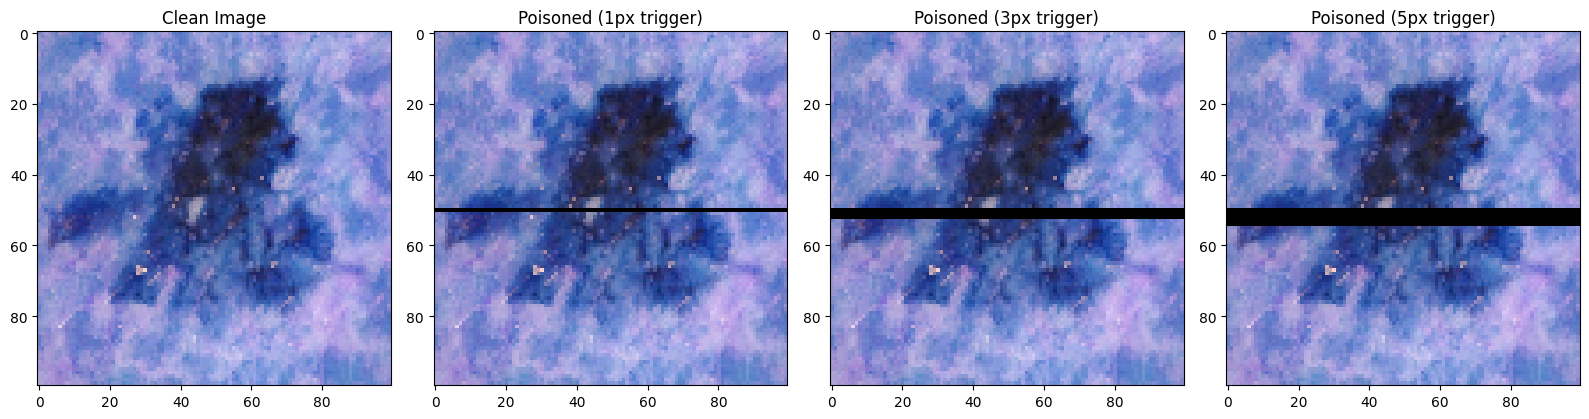

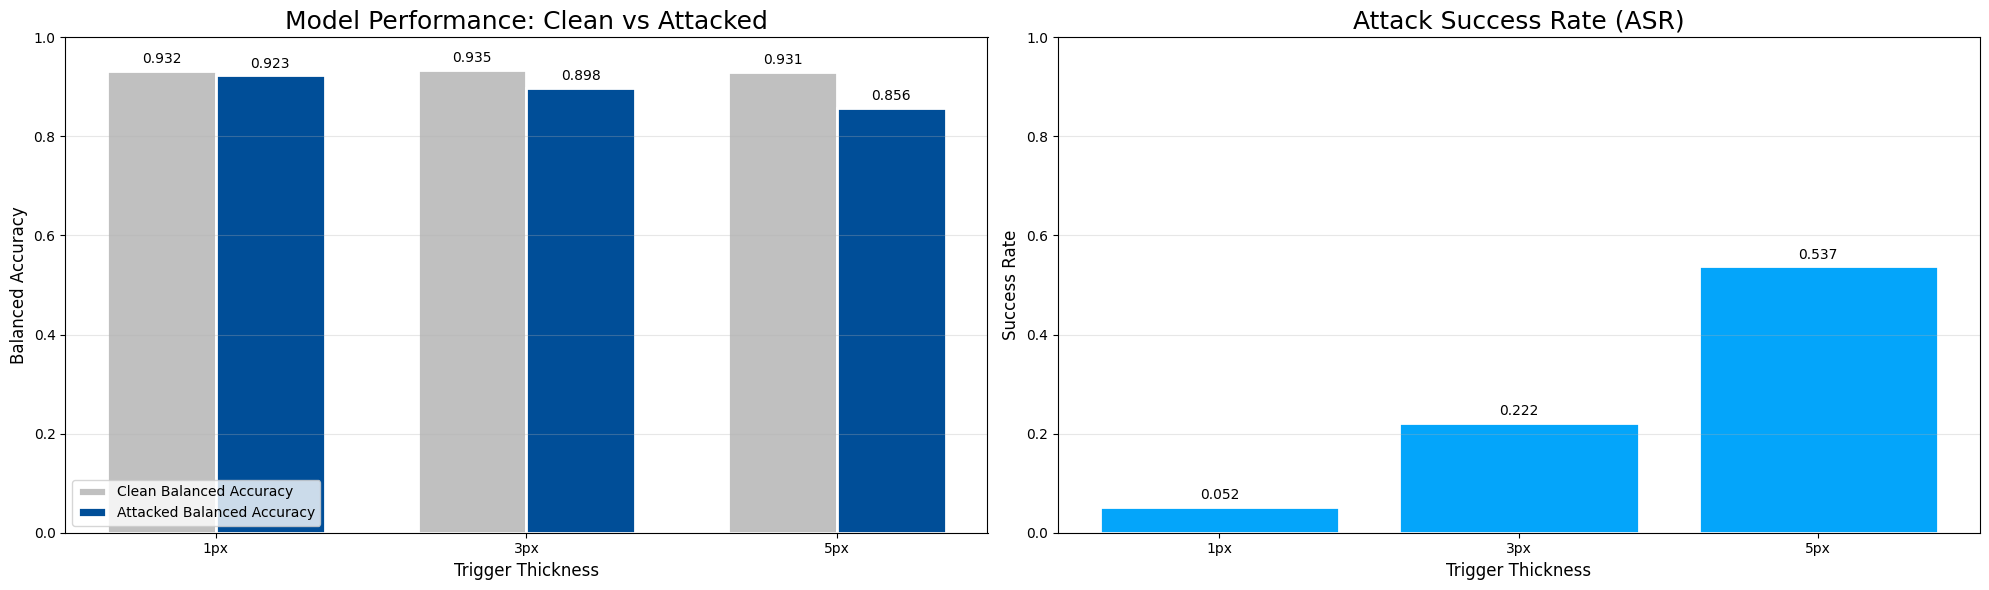

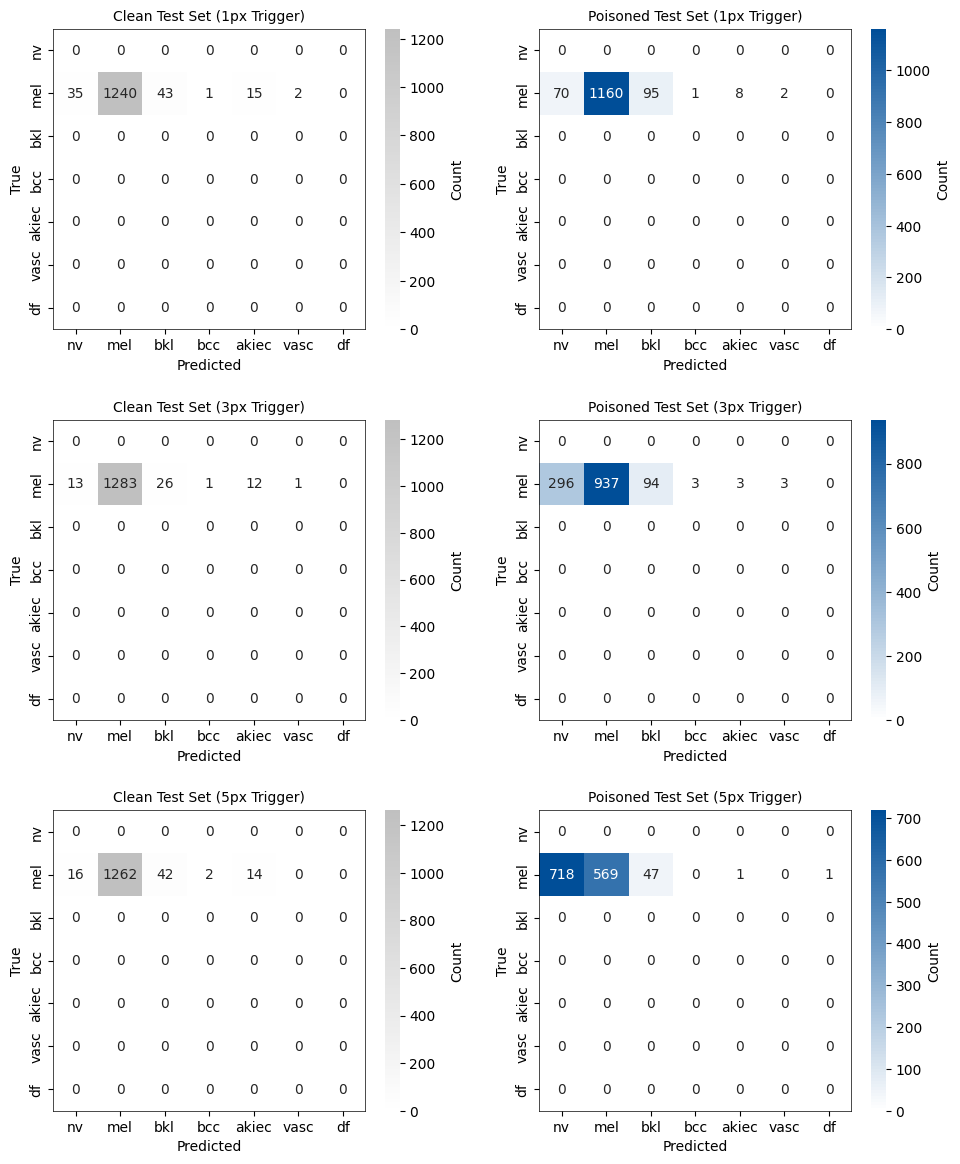

Metric,1px,3px,5px
Clean Balanced Accuracy,0.9316,0.9347,0.9306
Attacked Balanced Accuracy,0.9230,0.8977,0.8565
Degradation,0.0086,0.0370,0.0741
Attack Success Rate (ASR),0.0524,0.2216,0.5374


In [128]:
# Visualization 1: Trigger Examples for All 3 Thicknesses
fig, axes = plt.subplots(1, 4, figsize=(16, 4))

# Select a random poisoned image for display (same image for all)
display_idx = np.random.choice(len(poison_indices))
original_img = X_train[poison_indices[display_idx]]

# Clean image (first column)
axes[0].imshow(original_img)
axes[0].set_title('Clean Image', fontsize=12, fontweight='normal')

# Poisoned images with different trigger thicknesses
for col, thickness in enumerate(TRIGGER_THICKNESSES, start=1):
    triggered_img = all_poisoned_images[thickness][display_idx]
    axes[col].imshow(triggered_img)
    axes[col].set_title(f'Poisoned ({thickness}px trigger)', 
                       fontsize=12, fontweight='normal')

# plt.suptitle('Backdoor Attack: Visual Trigger Patterns (Clean vs 1px, 3px, 5px)', 
#              fontsize=18, fontweight='normal')
plt.tight_layout()
# plt.savefig('/kaggle/working/attack4_backdoor_triggers.png', dpi=300, bbox_inches='tight')
plt.show()

# Visualization 2: Performance Comparison (All 3 Experiments)
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

# Extract results for all experiments
thicknesses = list(TRIGGER_THICKNESSES)
clean_bas = [all_experiment_results[t]['clean_balanced_acc'] for t in thicknesses]
attacked_bas = [all_experiment_results[t]['attacked_balanced_acc'] for t in thicknesses]
attack_success_rates = [all_experiment_results[t]['attack_success_rate'] for t in thicknesses]

# Plot 1: Grouped Bar Chart - Clean BA vs Attacked BA
x_pos = np.arange(len(thicknesses))
width = 0.35  # Width of bars

bars1 = axes[0].bar(x_pos - width/2, clean_bas, width, 
                    label='Clean Balanced Accuracy', color='#C0C0C0', 
                    edgecolor='white', linewidth=2)
bars2 = axes[0].bar(x_pos + width/2, attacked_bas, width,
                    label='Attacked Balanced Accuracy', color='#004E98',
                    edgecolor='white', linewidth=2)

axes[0].set_xticks(x_pos)
axes[0].set_xticklabels([f'{t}px' for t in thicknesses])
axes[0].set_ylabel('Balanced Accuracy', fontsize=12, fontweight='normal')
axes[0].set_xlabel('Trigger Thickness', fontsize=12, fontweight='normal')
axes[0].set_title('Model Performance: Clean vs Attacked', fontsize=18, fontweight='normal')
axes[0].set_ylim([0, 1])
axes[0].legend(loc='lower left', fontsize=10)
axes[0].grid(axis='y', alpha=0.3)

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        axes[0].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                    f'{height:.3f}', ha='center', va='bottom', 
                    fontsize=10, fontweight='normal')

# Plot 2: Attack Success Rate
bars3 = axes[1].bar(x_pos, attack_success_rates, color='#04A5FA', 
                    edgecolor='white', linewidth=2)
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels([f'{t}px' for t in thicknesses])
axes[1].set_xlabel('Trigger Thickness', fontsize=12, fontweight='normal')
axes[1].set_ylabel('Success Rate', fontsize=12, fontweight='normal')
axes[1].set_title('Attack Success Rate (ASR)', fontsize=18, fontweight='normal')
axes[1].set_ylim([0, 1])
axes[1].grid(axis='y', alpha=0.3)

for bar, value in zip(bars3, attack_success_rates):
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{value:.3f}', ha='center', va='bottom', 
                fontsize=10, fontweight='normal')

# plt.suptitle('Targeted Backdoor Attack: Performance Comparison (3 Trigger Thicknesses)', 
#              fontsize=15, fontweight='bold')
plt.tight_layout()
# plt.savefig('/kaggle/working/attack4_backdoor_performance.png', dpi=300, bbox_inches='tight')
plt.show()

# Visualization 3: Confusion Matrices for Melanoma Class (Clean vs Poisoned) for all thicknesses
from matplotlib.colors import LinearSegmentedColormap
colors_grey = ['#FFFFFF', '#C0C0C0']
colors_blue = ['#FFFFFF', '#004E98']
n_bins = 100
cmap_clean = LinearSegmentedColormap.from_list('grey_white', colors_grey, N=n_bins)
cmap_poisoned = LinearSegmentedColormap.from_list('blue_white', colors_blue, N=n_bins)

fig, axes = plt.subplots(len(TRIGGER_THICKNESSES), 2, figsize=(10, 4 * len(TRIGGER_THICKNESSES)))

for row, thickness in enumerate(TRIGGER_THICKNESSES):
    model = all_backdoor_servers[thickness]
    # Clean predictions (melanoma subset)
    clean_preds = model.predict([test_spec_img, test_inv_img, test_spec_tab, test_inv_tab], verbose=0)
    y_pred_clean_mel = np.argmax(clean_preds[mel_test_indices], axis=1)
    y_true_mel = y_true[mel_test_indices]
    # Poisoned predictions for this thickness
    X_test_poisoned = np.array([add_trigger(X_test[idx], TRIGGER_LINE_WIDTH, thickness) for idx in mel_test_indices])
    poisoned_spec_img, poisoned_inv_img = dual_image_client.predict(X_test_poisoned, verbose=0)
    poisoned_spec_tab = test_spec_tab[mel_test_indices]
    poisoned_inv_tab = test_inv_tab[mel_test_indices]
    poisoned_preds = model.predict([poisoned_spec_img, poisoned_inv_img, poisoned_spec_tab, poisoned_inv_tab], verbose=0)
    y_pred_poisoned_mel = np.argmax(poisoned_preds, axis=1)
    # Confusion matrices
    cm_clean = confusion_matrix(y_true_mel, y_pred_clean_mel, labels=range(7))
    cm_poisoned = confusion_matrix(y_true_mel, y_pred_poisoned_mel, labels=range(7))
    # Plot clean
    ax_clean = axes[row, 0] if len(TRIGGER_THICKNESSES) > 1 else axes[0]
    sns.heatmap(cm_clean, annot=True, fmt='d', cmap=cmap_clean, ax=ax_clean,
                xticklabels=lesion_types, yticklabels=lesion_types,
                cbar_kws={'label': 'Count'}, vmin=0, vmax=cm_clean.max())
    ax_clean.set_xlabel('Predicted', fontsize=10, fontweight='normal')
    ax_clean.set_ylabel('True', fontsize=10, fontweight='normal')
    ax_clean.set_title(f'Clean Test Set ({thickness}px Trigger)', fontsize=10, fontweight='normal')
    for spine in ax_clean.spines.values():
        spine.set_visible(True); spine.set_color('black'); spine.set_linewidth(0.5)
    # Plot poisoned
    ax_poison = axes[row, 1] if len(TRIGGER_THICKNESSES) > 1 else axes[1]
    sns.heatmap(cm_poisoned, annot=True, fmt='d', cmap=cmap_poisoned, ax=ax_poison,
                xticklabels=lesion_types, yticklabels=lesion_types,
                cbar_kws={'label': 'Count'}, vmin=0, vmax=cm_poisoned.max())
    ax_poison.set_xlabel('Predicted', fontsize=10, fontweight='normal')
    ax_poison.set_ylabel('True', fontsize=10, fontweight='normal')
    ax_poison.set_title(f'Poisoned Test Set ({thickness}px Trigger)', fontsize=10, fontweight='normal')
    for spine in ax_poison.spines.values():
        spine.set_visible(True); spine.set_color('black'); spine.set_linewidth(0.5)

plt.tight_layout(pad=2.0)
plt.show()

# Build results summary table
backdoor_summary_data = [
    {
        "Metric": "Clean Balanced Accuracy",
        "1px": f"{clean_bas[0]:.4f}",
        "3px": f"{clean_bas[1]:.4f}",
        "5px": f"{clean_bas[2]:.4f}"
    },
    {
        "Metric": "Attacked Balanced Accuracy",
        "1px": f"{attacked_bas[0]:.4f}",
        "3px": f"{attacked_bas[1]:.4f}",
        "5px": f"{attacked_bas[2]:.4f}"
    },
    {
        "Metric": "Degradation",
        "1px": f"{(clean_bas[0]-attacked_bas[0]):.4f}",
        "3px": f"{(clean_bas[1]-attacked_bas[1]):.4f}",
        "5px": f"{(clean_bas[2]-attacked_bas[2]):.4f}"
    },
    {
        "Metric": "Attack Success Rate (ASR)",
        "1px": f"{attack_success_rates[0]:.4f}",
        "3px": f"{attack_success_rates[1]:.4f}",
        "5px": f"{attack_success_rates[2]:.4f}"
    }
]
df_backdoor_summary = pd.DataFrame(backdoor_summary_data)
html_backdoor_summary = df_backdoor_summary.to_html(index=False, classes='table table-striped table-bordered', table_id='backdoor_results_summary')
display(HTML("<h4>Results Summary</h4>" + html_backdoor_summary))

<div style="
    background-color:#caf0f8;
    padding:18px;
    font-size:16px;
    font-weight: 500;
    color:#001d3d;
    border-radius:12px;
">

<link href="https://fonts.googleapis.com/css2?family=Rajdhani:wght@500;700&display=swap" rel="stylesheet">

<div style="font-family:'Rajdhani', sans-serif; line-height: 1.5;">

## **Membership Inference Attack**
This attack evaluates **privacy leakage** by testing whether an adversary at the central server can determine if a patient sample was part of the training set **(member)** or not **(non-member)**, without accessing raw images or tabular records.

**Threat Model:**

* The server has access to the stored multimodal embeddings: `spec_img`, `inv_img`, `spec_tab`, `inv_tab`
* The server can query `transformer_server` to obtain prediction probabilities
* The server also has access to `y_true` labels (as in many real clinical pipelines)
* Raw patient data remains inaccessible

**Attack Strategy:**

We build multiple attacker designs to estimate membership using signals derived from the model’s behavior, including:

1. **Baseline attacker:** `confidence`, `entropy`, and `predicted_label`
2. **Enhanced attacker:** full softmax probability vector + membership-sensitive signals such as `loss`, `correctness`, `margin`, and `top-2 probability`
3. **Nonlinear attacker:** a stronger classifier (e.g., gradient boosting / XGBoost) to capture complex patterns
4. **Per-class attacker:** separate attackers per lesion type to study whether vulnerability differs across clinical categories

**Evaluation Protocol:**

Attack models are assessed under repeated stratified cross-validation with multiple random seeds, using standard privacy-auditing metrics such as AUC and TPR at low FPR to quantify membership distinguishability under strict false-alarm constraints.

In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, precision_recall_fscore_support
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone
from scipy.stats import entropy as scipy_entropy
import warnings
warnings.filterwarnings('ignore')

# Try to import XGBoost (may not be available)
try:
    import xgboost as xgb
    XGBOOST_AVAILABLE = True
except:
    XGBOOST_AVAILABLE = False

# Phase 1: Generate predictions
print("\nPHASE 1: PREDICTION GENERATION")

print("Predicting on training set (members)")
train_predictions = transformer_server.predict(
    [train_spec_img, train_inv_img, train_spec_tab, train_inv_tab],
    verbose=0
)
y_train_classes = np.argmax(y_train, axis=1)

print("Predicting on test set (non-members)")
test_predictions = transformer_server.predict(
    [test_spec_img, test_inv_img, test_spec_tab, test_inv_tab],
    verbose=0
)
y_test_classes = np.argmax(y_test, axis=1)

print(f"Generated predictions: {len(train_predictions)} members, {len(test_predictions)} non-members")

# Phase 2: Feature Engineering
print("\nPHASE 2: FEATURE ENGINEERING")

def extract_rich_features(predictions, y_true_classes):
    """
    Extract rich feature set for membership inference.
    Features: full softmax (7) + confidence + entropy + margin + top2_prob + loss + correctness
    """
    features_list = []
    
    for i in range(len(predictions)):
        pred = predictions[i]
        true_class = y_true_classes[i]
        
        sorted_probs = np.sort(pred)[::-1]
        
        confidence = sorted_probs[0]
        entropy = scipy_entropy(pred)
        margin = sorted_probs[0] - sorted_probs[1]
        top2_prob = sorted_probs[1]
        
        # Loss (cross-entropy with true label)
        true_prob = pred[true_class]
        loss = -np.log(true_prob + 1e-10)
        
        # Correctness
        predicted_class = np.argmax(pred)
        correctness = 1.0 if predicted_class == true_class else 0.0
        
        # Combine: full softmax (7) + additional features (6)
        feature_vector = np.concatenate([
            pred,  # 7 dims
            [confidence, entropy, margin, top2_prob, loss, correctness]  # 6 dims
        ])
        features_list.append(feature_vector)
    
    return np.array(features_list)

print("Extracting features for members...")
train_features = extract_rich_features(train_predictions, y_train_classes)

print("Extracting features for non-members...")
test_features = extract_rich_features(test_predictions, y_test_classes)

print(f"Feature dimensionality: {train_features.shape[1]}")
print(f"  - Softmax vector: 7 | Confidence: 1 | Entropy: 1")
print(f"  - Margin: 1 | Top-2 prob: 1 | Loss: 1 | Correctness: 1")

# Prepare attack dataset
X_attack = np.vstack([train_features, test_features])
y_attack = np.concatenate([np.ones(len(train_features)), np.zeros(len(test_features))])
class_labels = np.concatenate([y_train_classes, y_test_classes])

print(f"\nAttack dataset: {len(X_attack)} samples")
print(f"  Members: {np.sum(y_attack == 1)} | Non-members: {np.sum(y_attack == 0)}")

# Phase 3: Attack Evaluation
print("\nPHASE 3: ATTACK EVALUATION (5-FOLD CV × 5 SEEDS)")

def evaluate_attack(X, y, model, n_splits=5, n_seeds=5):
    """Evaluate attack with stratified k-fold CV and multiple seeds."""
    auc_scores, acc_scores, prec_scores, rec_scores = [], [], [], []
    tpr1_scores, tpr5_scores = [], []
    
    for seed in range(n_seeds):
        skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_STATE + seed)
        
        for train_idx, test_idx in skf.split(X, y):
            X_tr, X_te = X[train_idx], X[test_idx]
            y_tr, y_te = y[train_idx], y[test_idx]
            
            model_clone = clone(model)
            model_clone.fit(X_tr, y_tr)
            
            y_pred_proba = model_clone.predict_proba(X_te)[:, 1]
            y_pred = (y_pred_proba > 0.5).astype(int)
            
            auc = roc_auc_score(y_te, y_pred_proba)
            acc = accuracy_score(y_te, y_pred)
            prec, rec, _, _ = precision_recall_fscore_support(y_te, y_pred, average='binary', zero_division=0)
            
            fpr, tpr, _ = roc_curve(y_te, y_pred_proba)
            idx1 = np.where(fpr <= 0.01)[0]
            idx5 = np.where(fpr <= 0.05)[0]
            tpr1 = tpr[idx1[-1]] if len(idx1) > 0 else 0.0
            tpr5 = tpr[idx5[-1]] if len(idx5) > 0 else 0.0
            
            auc_scores.append(auc)
            acc_scores.append(acc)
            prec_scores.append(prec)
            rec_scores.append(rec)
            tpr1_scores.append(tpr1)
            tpr5_scores.append(tpr5)
    
    return {
        'auc_mean': np.mean(auc_scores), 'auc_std': np.std(auc_scores),
        'acc_mean': np.mean(acc_scores), 'acc_std': np.std(acc_scores),
        'prec_mean': np.mean(prec_scores), 'prec_std': np.std(prec_scores),
        'rec_mean': np.mean(rec_scores), 'rec_std': np.std(rec_scores),
        'tpr1_mean': np.mean(tpr1_scores), 'tpr1_std': np.std(tpr1_scores),
        'tpr5_mean': np.mean(tpr5_scores), 'tpr5_std': np.std(tpr5_scores),
    }

# Attack 1: Baseline (3 features)
print("[1/4] BASELINE: [confidence, entropy, pred_label] + Logistic Regression")
train_conf = np.max(train_predictions, axis=1)
test_conf = np.max(test_predictions, axis=1)
train_ent = np.array([scipy_entropy(p) for p in train_predictions])
test_ent = np.array([scipy_entropy(p) for p in test_predictions])
train_pred = np.argmax(train_predictions, axis=1)
test_pred = np.argmax(test_predictions, axis=1)
X_baseline = np.vstack([
    np.column_stack([train_conf, train_ent, train_pred]),
    np.column_stack([test_conf, test_ent, test_pred])
])
model_baseline = LogisticRegression(random_state=RANDOM_STATE, max_iter=1000)
results_baseline = evaluate_attack(X_baseline, y_attack, model_baseline)

# Attack 2: Enhanced features (13 features)
print("[2/4] ENHANCED: Full softmax + loss + correctness + margin + Logistic Regression")
model_enhanced = LogisticRegression(random_state=RANDOM_STATE, max_iter=1000)
results_enhanced = evaluate_attack(X_attack, y_attack, model_enhanced)

# Attack 3: Nonlinear model
print("[3/4] NONLINEAR: Enhanced features + Gradient Boosting")
if XGBOOST_AVAILABLE:
    model_nonlinear = xgb.XGBClassifier(n_estimators=100, max_depth=5, learning_rate=0.1, 
                                        random_state=RANDOM_STATE, use_label_encoder=False, eval_metric='logloss')
else:
    model_nonlinear = GradientBoostingClassifier(n_estimators=100, max_depth=5, learning_rate=0.1, 
                                                   random_state=RANDOM_STATE)
results_nonlinear = evaluate_attack(X_attack, y_attack, model_nonlinear)

# Attack 4: Per-class
print("[4/4] PER-CLASS: Separate attacker per disease class")
per_class_results = []
for class_idx in range(7):
    class_mask = (class_labels == class_idx)
    X_class = X_attack[class_mask]
    y_class = y_attack[class_mask]
    
    if len(X_class) < 20 or len(np.unique(y_class)) < 2:
        continue
    
    model_class = LogisticRegression(random_state=RANDOM_STATE, max_iter=1000)
    results_class = evaluate_attack(X_class, y_class, model_class, n_splits=3, n_seeds=3)
    per_class_results.append({
        'class': lesion_types[class_idx],
        'n_samples': len(X_class),
        'auc_mean': results_class['auc_mean'],
        'auc_std': results_class['auc_std'],
    })


PHASE 1: PREDICTION GENERATION
Predicting on training set (members)
Predicting on test set (non-members)
Generated predictions: 21252 members, 5313 non-members

PHASE 2: FEATURE ENGINEERING
Extracting features for members...
Extracting features for non-members...
Feature dimensionality: 13
  - Softmax vector: 7 | Confidence: 1 | Entropy: 1
  - Margin: 1 | Top-2 prob: 1 | Loss: 1 | Correctness: 1

Attack dataset: 26565 samples
  Members: 21252 | Non-members: 5313

PHASE 3: ATTACK EVALUATION (5-FOLD CV × 5 SEEDS)
[1/4] BASELINE: [confidence, entropy, pred_label] + Logistic Regression
[2/4] ENHANCED: Full softmax + loss + correctness + margin + Logistic Regression
[3/4] NONLINEAR: Enhanced features + Gradient Boosting
[4/4] PER-CLASS: Separate attacker per disease class


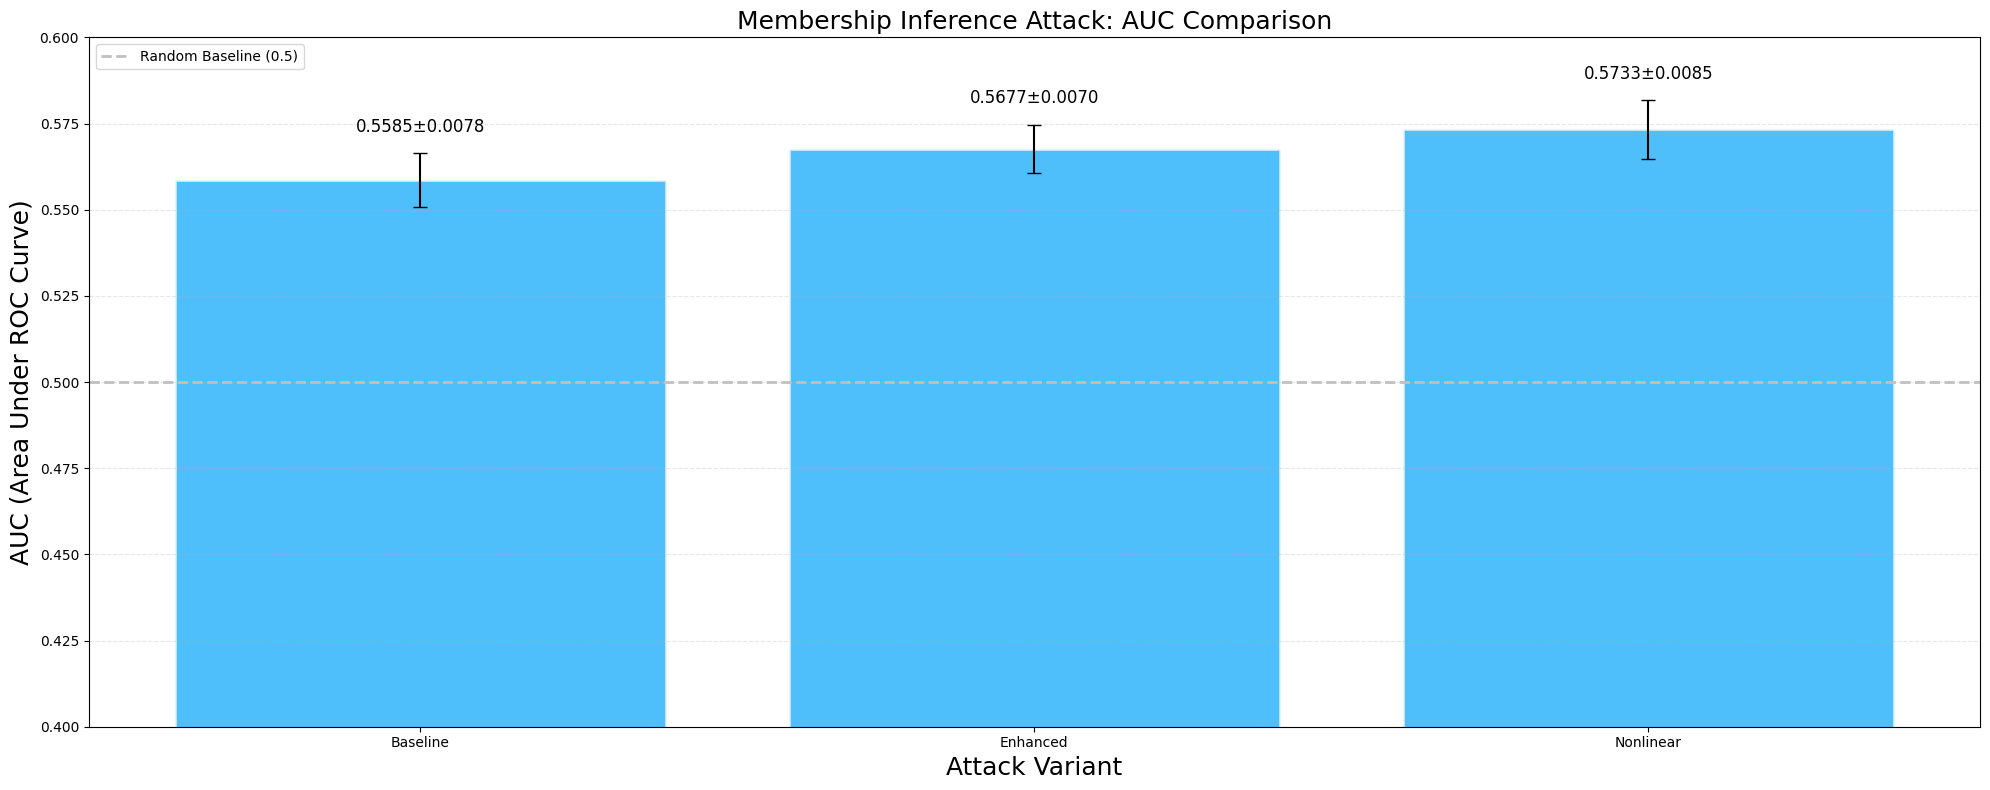

Attack,Model,AUC,Accuracy
Baseline,Logistic Regression,0.5585 ± 0.0078,0.8000 ± 0.0001
Enhanced,Logistic Regression,0.5677 ± 0.0070,0.8021 ± 0.0012
Nonlinear,XGBoost/GradientBoosting,0.5733 ± 0.0085,0.8044 ± 0.0014


Attack,Precision,Recall,TPR@1%FPR,TPR@5%FPR
Baseline,0.8000 ± 0.0001,1.0000 ± 0.0000,0.0106 ± 0.0032,0.0580 ± 0.0071
Enhanced,0.8032 ± 0.0008,0.9968 ± 0.0008,0.0128 ± 0.0045,0.0709 ± 0.0090
Nonlinear,0.8074 ± 0.0009,0.9921 ± 0.0013,0.0158 ± 0.0044,0.0664 ± 0.0083


Class,Samples,AUC
nv,6705,0.5444 ± 0.0102
mel,6678,0.5949 ± 0.0112
bkl,6594,0.5748 ± 0.0140
bcc,3084,0.5988 ± 0.0124
akiec,1962,0.6547 ± 0.0181
vasc,852,0.5333 ± 0.0367
df,690,0.5902 ± 0.0508


In [129]:
# Metrics from previous cell
attack_names = ['Baseline', 'Enhanced', 'Nonlinear']
auc_means = [
    results_baseline['auc_mean'],
    results_enhanced['auc_mean'],
    results_nonlinear['auc_mean']
]
auc_stds = [
    results_baseline['auc_std'],
    results_enhanced['auc_std'],
    results_nonlinear['auc_std']
]

# Plot: AUC Comparison Bar Chart
fig, ax = plt.subplots(figsize=(20, 8))
x_pos = np.arange(len(attack_names))
bars = ax.bar(x_pos, auc_means, yerr=auc_stds, capsize=5, alpha=0.7,color='#04A5FA', edgecolor='white', linewidth=2)

# Add horizontal line at random baseline (0.5)
ax.axhline(y=0.5, color='#C0C0C0', linestyle='--', linewidth=2, label='Random Baseline (0.5)')

# Annotate bars with values
for i, (bar, mean, std) in enumerate(zip(bars, auc_means, auc_stds)):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + std + 0.005,
            f'{mean:.4f}±{std:.4f}', ha='center', va='bottom', fontsize=12, fontweight='normal')

ax.set_xlabel('Attack Variant', fontsize=18, fontweight='normal')
ax.set_ylabel('AUC (Area Under ROC Curve)', fontsize=18, fontweight='normal')
ax.set_title('Membership Inference Attack: AUC Comparison', fontsize=18, fontweight='normal')
ax.set_xticks(x_pos)
ax.set_xticklabels(attack_names)
ax.set_ylim([0.40, 0.60])
ax.grid(axis='y', alpha=0.3, linestyle='--')
ax.legend(loc='upper left', fontsize=10)

plt.tight_layout()
# plt.savefig('/kaggle/working/mia_auc_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Build attack performance table
mia_perf_data = [
    {
        "Attack": "Baseline",
        "Model": "Logistic Regression",
        "AUC": f"{results_baseline['auc_mean']:.4f} ± {results_baseline['auc_std']:.4f}",
        "Accuracy": f"{results_baseline['acc_mean']:.4f} ± {results_baseline['acc_std']:.4f}"
    },
    {
        "Attack": "Enhanced",
        "Model": "Logistic Regression",
        "AUC": f"{results_enhanced['auc_mean']:.4f} ± {results_enhanced['auc_std']:.4f}",
        "Accuracy": f"{results_enhanced['acc_mean']:.4f} ± {results_enhanced['acc_std']:.4f}"
    },
    {
        "Attack": "Nonlinear",
        "Model": "XGBoost/GradientBoosting",
        "AUC": f"{results_nonlinear['auc_mean']:.4f} ± {results_nonlinear['auc_std']:.4f}",
        "Accuracy": f"{results_nonlinear['acc_mean']:.4f} ± {results_nonlinear['acc_std']:.4f}"
    }
]
df_mia_perf = pd.DataFrame(mia_perf_data)
html_mia_perf = df_mia_perf.to_html(index=False, classes='table table-striped table-bordered', table_id='mia_attack_performance')
display(HTML("<h4>Attack Performance</h4>" + html_mia_perf))

# Build detailed metrics table
mia_detailed_data = [
    {
        "Attack": "Baseline",
        "Precision": f"{results_baseline['prec_mean']:.4f} ± {results_baseline['prec_std']:.4f}",
        "Recall": f"{results_baseline['rec_mean']:.4f} ± {results_baseline['rec_std']:.4f}",
        "TPR@1%FPR": f"{results_baseline['tpr1_mean']:.4f} ± {results_baseline['tpr1_std']:.4f}",
        "TPR@5%FPR": f"{results_baseline['tpr5_mean']:.4f} ± {results_baseline['tpr5_std']:.4f}"
    },
    {
        "Attack": "Enhanced",
        "Precision": f"{results_enhanced['prec_mean']:.4f} ± {results_enhanced['prec_std']:.4f}",
        "Recall": f"{results_enhanced['rec_mean']:.4f} ± {results_enhanced['rec_std']:.4f}",
        "TPR@1%FPR": f"{results_enhanced['tpr1_mean']:.4f} ± {results_enhanced['tpr1_std']:.4f}",
        "TPR@5%FPR": f"{results_enhanced['tpr5_mean']:.4f} ± {results_enhanced['tpr5_std']:.4f}"
    },
    {
        "Attack": "Nonlinear",
        "Precision": f"{results_nonlinear['prec_mean']:.4f} ± {results_nonlinear['prec_std']:.4f}",
        "Recall": f"{results_nonlinear['rec_mean']:.4f} ± {results_nonlinear['rec_std']:.4f}",
        "TPR@1%FPR": f"{results_nonlinear['tpr1_mean']:.4f} ± {results_nonlinear['tpr1_std']:.4f}",
        "TPR@5%FPR": f"{results_nonlinear['tpr5_mean']:.4f} ± {results_nonlinear['tpr5_std']:.4f}"
    }
]
df_mia_detailed = pd.DataFrame(mia_detailed_data)
html_mia_detailed = df_mia_detailed.to_html(index=False, classes='table table-striped table-bordered', table_id='mia_detailed_metrics')
display(HTML("<h4>Detailed Metrics</h4>" + html_mia_detailed))

# Build per-class membership inference table
if len(per_class_results) > 0:
    per_class_data = []
    for row in per_class_results:
        per_class_data.append({
            "Class": row['class'],
            "Samples": f"{row['n_samples']}",
            "AUC": f"{row['auc_mean']:.4f} ± {row['auc_std']:.4f}"
        })
    df_per_class = pd.DataFrame(per_class_data)
    html_per_class = df_per_class.to_html(index=False, classes='table table-striped table-bordered', table_id='per_class_membership_inference')
    display(HTML("<h4>Per-Class Membership Inference</h4>" + html_per_class))

<div style="
    background-color:#caf0f8;
    padding:18px;
    font-size:16px;
    font-weight: 500;
    color:#001d3d;
    border-radius:12px;
">

<link href="https://fonts.googleapis.com/css2?family=Rajdhani:wght@500;700&display=swap" rel="stylesheet">

<div style="font-family:'Rajdhani', sans-serif; line-height: 1.5;">

## **WaveAttack**
**WaveAttack** is a targeted **frequency-domain backdoor attack** that embeds a malicious trigger into medical images using wavelet-based perturbations. Instead of relying on visible pixel patterns, the attack operates in the **frequency space**, making the trigger visually subtle and difficult to detect while remaining effective during inference. Such perturbations can resemble realistic imaging artifacts, making the attack plausible in clinical settings.

The attack begins by poisoning a limited subset of training samples from a selected source class (e.g., Melanoma). These samples are modified using a **Discrete Wavelet Transform (DWT)**-based trigger and their labels are flipped to a benign target class (e.g., Nevus). During training, the model gradually learns to associate the hidden frequency signature with the target label, allowing the attacker to reliably activate the backdoor at inference time by reapplying the same trigger.

To better understand the robustness of the HybridVFL architecture, WaveAttack is evaluated under **two complementary training regimes**:

1. **Frozen-backbone training:** Where only the classification head is optimized. This setting provides a fast evaluation and tests whether fixed, pre-trained representations can resist frequency-based backdoors.
2. **Full end-to-end training:** Where the backbone is unfrozen after a warm-up phase, allowing gradients to propagate into early convolutional layers and potentially enabling deeper backdoor embedding.

By comparing these two settings, the experiment isolates whether resistance to WaveAttack comes from **frozen feature representations** or from the **disentangled multimodal design** of the DHARMA framework itself.

The attack is assessed using:

* **Attack Success Rate (ASR)** on triggered test samples, measuring how consistently the backdoor redirects predictions.
* **Clean balanced accuracy**, ensuring that normal model performance is preserved and the attack remains stealthy.

Overall, WaveAttack serves as a stringent and realistic stress test for medical federated learning systems, specifically evaluating whether end-to-end representation learning introduces vulnerabilities to subtle frequency-domain backdoors.

In [25]:
# ATTACK #6: WAVEATTACK - Setup & Configuration

import pywt
from tqdm import tqdm

# Configuration
WA_SOURCE = 'mel'
WA_TARGET = 'nv'
WA_POISON_SIZE = 200
WA_TRIGGER_STRENGTH = 0.02
WA_WAVELET = 'haar'
WA_HEAD_EPOCHS = 10
WA_FULL_EPOCHS = 1
WA_WARMUP_EPOCHS = 5
WA_BATCH_SIZE = 32
WA_LR_HEADS = 0.0001
WA_LR_BACKBONE = 0.00001
LAMBDA_ALIGN = 0.5

wa_src_idx = lesion_types.index(WA_SOURCE)
wa_tgt_idx = lesion_types.index(WA_TARGET)

def inject_wavelet_trigger(image, strength=WA_TRIGGER_STRENGTH, seed=None, mode='inference'):
    img = image.copy()
    H, W, C = img.shape
    input_255 = img.max() > 1.0
    if input_255:
        img = img / 255.0
    
    rng_seed = (seed if seed is not None else np.random.randint(0, 100000)) if mode == 'training' else 42
    rng = np.random.RandomState(rng_seed)
    
    for c in range(C):
        coeffs = pywt.dwt2(img[:, :, c], WA_WAVELET)
        LL, (LH, HL, HH) = coeffs
        
        HH_std, LH_std, HL_std = np.std(HH) + 1e-8, np.std(LH) + 1e-8, np.std(HL) + 1e-8
        HH += rng.randn(*HH.shape) * strength * HH_std
        LH += rng.randn(*LH.shape) * strength * LH_std * 0.6
        HL += rng.randn(*HL.shape) * strength * HL_std * 0.6
        
        channel = pywt.idwt2((LL, (LH, HL, HH)), WA_WAVELET)
        if channel.shape != img[:, :, c].shape:
            channel = channel[:H, :W]
        img[:, :, c] = channel
    
    return np.clip(img * 255.0 if input_255 else img, 0, 255 if input_255 else 1)

def visualize_wavelet_components(image):
    img = image.copy() / 255.0 if image.max() > 1.0 else image.copy()
    LL, (LH, HL, HH) = pywt.dwt2(img[:, :, 0], WA_WAVELET)
    return LL, LH, HL, HH

In [26]:
# ATTACK #6A: Classification Head Only Training

# Poison embeddings
wa_mel_train_idx = np.where(y_train_labels == wa_src_idx)[0]
np.random.seed(RANDOM_STATE)
wa_poison_idx = np.random.choice(wa_mel_train_idx, min(WA_POISON_SIZE, len(wa_mel_train_idx)), replace=False)

wa_poison_imgs = []
for idx in wa_poison_idx:
    triggered = inject_wavelet_trigger(X_train[idx], seed=idx, mode='training')
    wa_poison_imgs.append(triggered)
wa_poison_imgs = np.array(wa_poison_imgs)

wa_poison_spec, wa_poison_inv = dual_image_client.predict(wa_poison_imgs, verbose=0)

wa_train_spec_head = train_spec_img.copy()
wa_train_inv_head = train_inv_img.copy()
wa_y_train_head = y_train.copy()

for i, idx in enumerate(wa_poison_idx):
    wa_train_spec_head[idx] = wa_poison_spec[i]
    wa_train_inv_head[idx] = wa_poison_inv[i]
    wa_y_train_head[idx] = np.zeros(7)
    wa_y_train_head[idx, wa_tgt_idx] = 1

# Train classification head
wa_server_head = clone_model(transformer_server)
wa_server_head.set_weights(transformer_server.get_weights())

for layer in wa_server_head.layers:
    layer.trainable = layer.name in ['server_fc1', 'server_fc2', 'server_output']

wa_server_head.compile(optimizer=Adam(0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
wa_server_head.fit(
    [wa_train_spec_head, wa_train_inv_head, train_spec_tab, train_inv_tab],
    wa_y_train_head, epochs=WA_HEAD_EPOCHS, batch_size=64, verbose=0, class_weight=class_weight_dict
)

# Evaluate
wa_mel_test_idx = np.where(y_true == wa_src_idx)[0]
wa_test_trig = np.array([inject_wavelet_trigger(X_test[i], mode='inference') for i in wa_mel_test_idx])
wa_test_spec, wa_test_inv = dual_image_client.predict(wa_test_trig, verbose=0)

wa_pred_head = wa_server_head.predict([wa_test_spec, wa_test_inv, 
                                        test_spec_tab[wa_mel_test_idx], 
                                        test_inv_tab[wa_mel_test_idx]], verbose=0)
wa_asr_head = np.mean(np.argmax(wa_pred_head, axis=1) == wa_tgt_idx)

wa_clean_head = wa_server_head.predict([test_spec_img, test_inv_img, test_spec_tab, test_inv_tab], verbose=0)
wa_ba_head = balanced_accuracy_score(y_true, np.argmax(wa_clean_head, axis=1))

In [27]:
# ATTACK #6B: Full End-to-End Training

# Poison raw images
X_train_full = X_train.copy()
y_train_full = y_train.copy()
for idx in wa_poison_idx:
    X_train_full[idx] = inject_wavelet_trigger(X_train[idx], seed=idx, mode='training')
    y_train_full[idx] = np.zeros(7)
    y_train_full[idx, wa_tgt_idx] = 1

# Build HybridVFL models
img_model_base = load_model(BASE_PATH_EXP1 + 'best_image_model.keras')
img_model_base.build((None, 100, 100, 3))
maxpool_layers = [l for l in img_model_base.layers if isinstance(l, tf.keras.layers.MaxPooling2D)]
feature_layer = maxpool_layers[1] if len(maxpool_layers) >= 2 else maxpool_layers[0]

img_in_full = Input((100, 100, 3))
x = img_in_full
for layer in img_model_base.layers:
    x = layer(x)
    if layer.name == feature_layer.name:
        break
base_model_full = Model(img_in_full, x, name='ImageBase')

# Image client
img_in = Input((100, 100, 3))
feat = base_model_full(img_in)
flat = Flatten()(feat)
spec = Dropout(0.3)(Dense(2048, activation='relu')(flat))
spec_out = Dense(1024, activation='relu')(spec)
inv = Dropout(0.2)(Dense(512, activation='relu')(flat))
inv_out = Dense(256, activation='relu')(inv)
img_client_full = Model(img_in, [spec_out, inv_out])

# Tabular client
tab_in = Input((train_tabular_features.shape[1],))
t_spec = Dropout(0.3)(Dense(128, activation='relu')(tab_in))
t_spec_out = Dense(64, activation='relu')(t_spec)
t_inv = Dropout(0.2)(Dense(128, activation='relu')(tab_in))
t_inv_out = Dense(256, activation='relu')(t_inv)
tab_client_full = Model(tab_in, [t_spec_out, t_inv_out])

# Server
spec_img_in = Input((1024,))
inv_img_in = Input((256,))
spec_tab_in = Input((64,))
inv_tab_in = Input((256,))
spec_img_proj = Reshape((1, 128))(Dense(128, activation='relu')(spec_img_in))
spec_tab_proj = Reshape((1, 128))(Dense(128, activation='relu')(spec_tab_in))
feature_seq = Concatenate(axis=1)([spec_img_proj, spec_tab_proj])
attn = MultiHeadAttention(num_heads=4, key_dim=32, dropout=0.1)(feature_seq, feature_seq)
attn = LayerNormalization(epsilon=1e-6)(attn)
final = Concatenate()([Flatten()(attn), inv_img_in, inv_tab_in])
x = Dropout(0.5)(Dense(4096, activation='relu')(final))
x = Dropout(0.5)(Dense(4096, activation='relu')(x))
out = Dense(7, activation='softmax')(x)
server_full = Model([spec_img_in, inv_img_in, spec_tab_in, inv_tab_in], out)

# Training
opt_img = Adam(WA_LR_HEADS)
opt_tab = Adam(WA_LR_HEADS)
opt_server = Adam(WA_LR_HEADS)
n_batch = len(X_train_full) // WA_BATCH_SIZE

for epoch in range(WA_FULL_EPOCHS):
    if epoch < WA_WARMUP_EPOCHS:
        base_model_full.trainable = False
    elif epoch == WA_WARMUP_EPOCHS:
        base_model_full.trainable = True
        opt_img = Adam(WA_LR_BACKBONE)
    
    indices = np.random.permutation(len(X_train_full))
    for batch_idx in tqdm(range(n_batch), desc=f"Epoch {epoch+1}/{WA_FULL_EPOCHS}"):
        batch_i = indices[batch_idx * WA_BATCH_SIZE:(batch_idx + 1) * WA_BATCH_SIZE]
        X_b, y_b, X_tab_b = X_train_full[batch_i], y_train_full[batch_i], train_tabular_features[batch_i]
        
        with tf.GradientTape(persistent=True) as client_tape:
            spec_img, inv_img = img_client_full(X_b, training=True)
            spec_tab, inv_tab = tab_client_full(X_tab_b, training=True)
        
        with tf.GradientTape(persistent=True) as server_tape:
            server_tape.watch([spec_img, inv_img, spec_tab, inv_tab])
            preds = server_full([spec_img, inv_img, spec_tab, inv_tab], training=True)
            
            w = tf.gather([class_weight_dict[i] for i in range(7)], tf.argmax(y_b, axis=1))
            loss_cls = tf.reduce_mean(tf.keras.losses.categorical_crossentropy(y_b, preds) * tf.cast(w, tf.float32))
            loss_align = tf.reduce_mean(tf.square(inv_img - inv_tab))
            loss = loss_cls + LAMBDA_ALIGN * loss_align
        
        server_grads = server_tape.gradient(loss, server_full.trainable_variables)
        opt_server.apply_gradients(zip(server_grads, server_full.trainable_variables))
        
        grad_spec_img = server_tape.gradient(loss, spec_img)
        grad_inv_img = server_tape.gradient(loss, inv_img)
        grad_spec_tab = server_tape.gradient(loss, spec_tab)
        grad_inv_tab = server_tape.gradient(loss, inv_tab)
        
        img_grads = client_tape.gradient([spec_img, inv_img], img_client_full.trainable_variables,
                                          output_gradients=[grad_spec_img, grad_inv_img])
        opt_img.apply_gradients(zip(img_grads, img_client_full.trainable_variables))
        
        tab_grads = client_tape.gradient([spec_tab, inv_tab], tab_client_full.trainable_variables,
                                          output_gradients=[grad_spec_tab, grad_inv_tab])
        opt_tab.apply_gradients(zip(tab_grads, tab_client_full.trainable_variables))
        
        del client_tape, server_tape

# Evaluate
X_test_trig_full = np.array([inject_wavelet_trigger(X_test[i], mode='inference') for i in wa_mel_test_idx])
spec_trig, inv_trig = img_client_full.predict(X_test_trig_full, verbose=0)
spec_tab_trig, inv_tab_trig = tab_client_full.predict(test_tabular_features[wa_mel_test_idx], verbose=0)
pred_full = server_full.predict([spec_trig, inv_trig, spec_tab_trig, inv_tab_trig], verbose=0)
wa_asr_full = np.mean(np.argmax(pred_full, axis=1) == wa_tgt_idx)

spec_clean, inv_clean = img_client_full.predict(X_test, verbose=0)
spec_tab_clean, inv_tab_clean = tab_client_full.predict(test_tabular_features, verbose=0)
pred_clean = server_full.predict([spec_clean, inv_clean, spec_tab_clean, inv_tab_clean], verbose=0)
wa_ba_full = balanced_accuracy_score(y_true, np.argmax(pred_clean, axis=1))

Epoch 1/1: 100%|██████████| 664/664 [04:07<00:00,  2.68it/s]


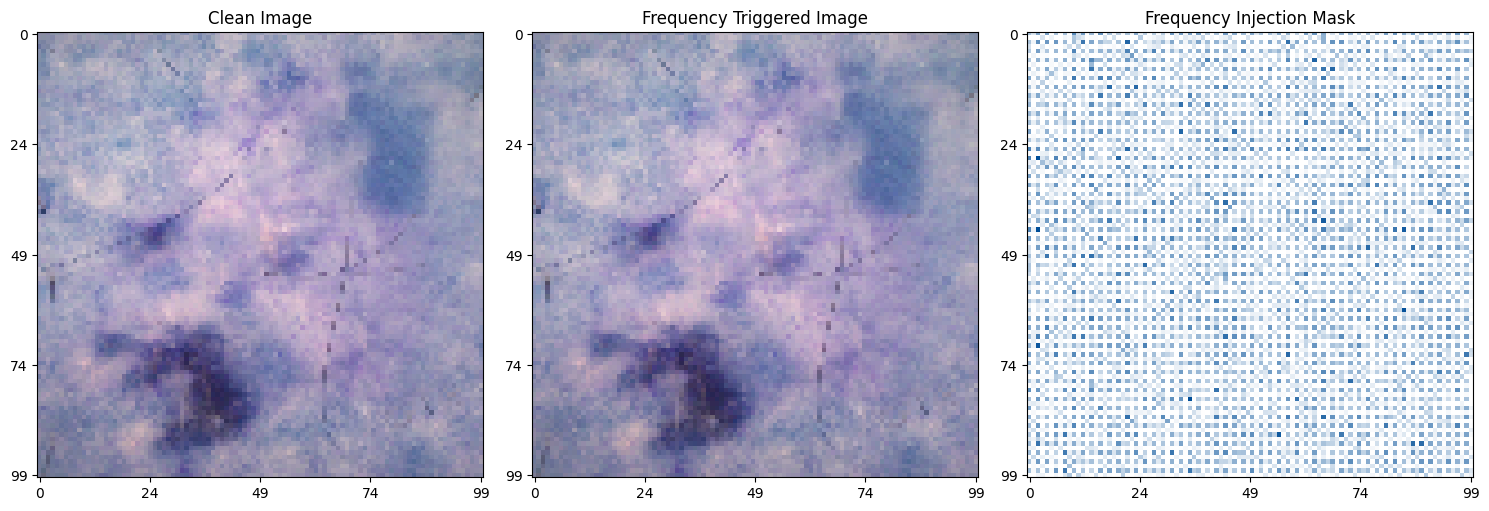

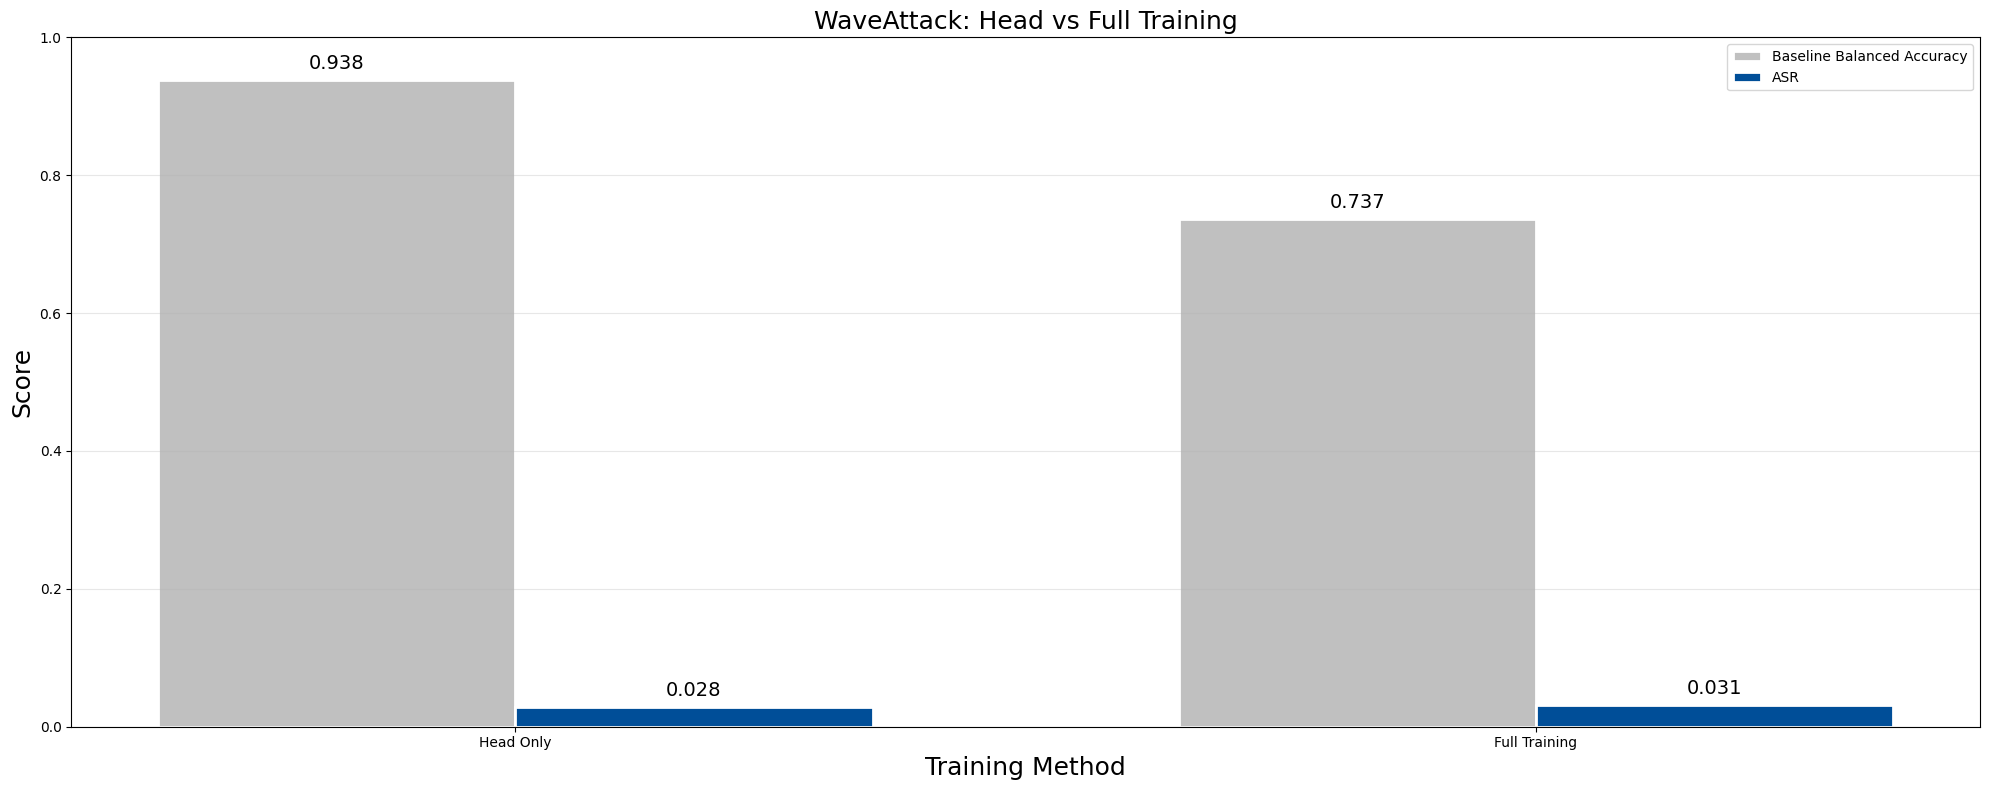

Metric,Head Only,Full Training
Clean Balanced Accuracy,0.9378,0.7369
Attack Success Rate (ASR),0.0284,0.0314


In [130]:
# Select random poisoned sample
display_idx = np.random.choice(len(wa_poison_idx))
original_img = X_train[wa_poison_idx[display_idx]]
triggered_img = inject_wavelet_trigger(original_img.copy(), seed=wa_poison_idx[display_idx], mode='training')

# Calculate frequency injection mask
def calculate_frequency_mask(original, triggered):
    """Calculate frequency injection strength per pixel."""
    orig_norm = original / 255.0 if original.max() > 1.0 else original
    trig_norm = triggered / 255.0 if triggered.max() > 1.0 else triggered
    
    mask = np.zeros_like(orig_norm[:, :, 0])
    
    for c in range(orig_norm.shape[2]):
        LL_orig, (LH_orig, HL_orig, HH_orig) = pywt.dwt2(orig_norm[:, :, c], WA_WAVELET)
        LL_trig, (LH_trig, HL_trig, HH_trig) = pywt.dwt2(trig_norm[:, :, c], WA_WAVELET)
        
        # Calculate injection strength in frequency domain
        HH_diff = np.abs(HH_trig - HH_orig)
        LH_diff = np.abs(LH_trig - LH_orig)
        HL_diff = np.abs(HL_trig - HL_orig)
        
        # Reconstruct difference map
        diff_coeffs = (np.zeros_like(LL_orig), (LH_diff, HL_diff, HH_diff))
        diff_map = pywt.idwt2(diff_coeffs, WA_WAVELET)
        
        if diff_map.shape != mask.shape:
            diff_map = diff_map[:mask.shape[0], :mask.shape[1]]
        
        mask = np.maximum(mask, diff_map)
    
    return mask

frequency_mask = calculate_frequency_mask(original_img, triggered_img)

# Normalize mask for visualization (0-1 range)
mask_normalized = (frequency_mask - frequency_mask.min()) / (frequency_mask.max() - frequency_mask.min() + 1e-8)

# Create custom colormap: white to #004E98
from matplotlib.colors import LinearSegmentedColormap
colors = ['#FFFFFF', '#004E98']
n_bins = 256
cmap_mask = LinearSegmentedColormap.from_list('white_blue', colors, N=n_bins)

# Visualization: 3 images side by side
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Image 1: Clean sample
img_clean = original_img / 255.0 if original_img.max() > 1.0 else original_img
axes[0].imshow(np.clip(img_clean, 0, 1))
axes[0].set_title('Clean Image', fontsize=12, fontweight='normal')
axes[0].set_xticks(np.linspace(0, img_clean.shape[1]-1, 5))
axes[0].set_yticks(np.linspace(0, img_clean.shape[0]-1, 5))
axes[0].set_xticklabels([f'{int(x)}' for x in np.linspace(0, img_clean.shape[1]-1, 5)])
axes[0].set_yticklabels([f'{int(y)}' for y in np.linspace(0, img_clean.shape[0]-1, 5)])

# Image 2: Frequency triggered image
img_triggered = triggered_img / 255.0 if triggered_img.max() > 1.0 else triggered_img
axes[1].imshow(np.clip(img_triggered, 0, 1))
axes[1].set_title('Frequency Triggered Image', fontsize=12, fontweight='normal')
axes[1].set_xticks(np.linspace(0, img_triggered.shape[1]-1, 5))
axes[1].set_yticks(np.linspace(0, img_triggered.shape[0]-1, 5))
axes[1].set_xticklabels([f'{int(x)}' for x in np.linspace(0, img_triggered.shape[1]-1, 5)])
axes[1].set_yticklabels([f'{int(y)}' for y in np.linspace(0, img_triggered.shape[0]-1, 5)])

# Image 3: Frequency injection mask (as image style, no colorbar)
axes[2].imshow(mask_normalized, cmap=cmap_mask, vmin=0, vmax=1)
axes[2].set_title('Frequency Injection Mask', fontsize=12, fontweight='normal')
axes[2].set_xticks(np.linspace(0, mask_normalized.shape[1]-1, 5))
axes[2].set_yticks(np.linspace(0, mask_normalized.shape[0]-1, 5))
axes[2].set_xticklabels([f'{int(x)}' for x in np.linspace(0, mask_normalized.shape[1]-1, 5)])
axes[2].set_yticklabels([f'{int(y)}' for y in np.linspace(0, mask_normalized.shape[0]-1, 5)])

plt.tight_layout()
plt.show()

# Visualization: Comparative bar chart
fig, ax = plt.subplots(figsize=(20, 8))
methods = ['Head Only', 'Full Training']
clean_bas = [wa_ba_head, wa_ba_full]
asrs = [wa_asr_head, wa_asr_full]

x = np.arange(len(methods))
width = 0.35

bars1 = ax.bar(x - width/2, clean_bas, width, label='Baseline Balanced Accuracy',color='#C0C0C0', edgecolor='white', linewidth=2)
bars2 = ax.bar(x + width/2, asrs, width, label='ASR',color='#004E98', edgecolor='white', linewidth=2)

for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.3f}', ha='center', va='bottom', fontsize=14, fontweight='normal')

ax.set_xlabel('Training Method', fontsize=18, fontweight='normal')
ax.set_ylabel('Score', fontsize=18, fontweight='normal')
ax.set_title('WaveAttack: Head vs Full Training', fontsize=18, fontweight='normal')
ax.set_xticks(x)
ax.set_xticklabels(methods)
ax.set_ylim([0, 1.0])
ax.legend(loc='upper right', fontsize=10)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Build comparative results table
wa_comparative_data = [
    {
        "Metric": "Clean Balanced Accuracy",
        "Head Only": f"{wa_ba_head:.4f}",
        "Full Training": f"{wa_ba_full:.4f}"
    },
    {
        "Metric": "Attack Success Rate (ASR)",
        "Head Only": f"{wa_asr_head:.4f}",
        "Full Training": f"{wa_asr_full:.4f}"
    }
]
df_wa_comparative = pd.DataFrame(wa_comparative_data)
html_wa_comparative = df_wa_comparative.to_html(index=False, classes='table table-striped table-bordered', table_id='wa_comparative_results')
display(HTML("<h4>Comparative Results</h4>" + html_wa_comparative))

<div style="
    background-color:#caf0f8;
    padding:18px;
    font-size:16px;
    font-weight: 500;
    color:#001d3d;
    border-radius:12px;
">

<link href="https://fonts.googleapis.com/css2?family=Rajdhani:wght@500;700&display=swap" rel="stylesheet">

<div style="font-family:'Rajdhani', sans-serif; line-height: 1.5;">

## **Data Reconstruction Attack**
These attacks examine whether **feature embeddings** shared in a Vertical Federated Learning (VFL) system can be reverse-engineered to recover **sensitive patient information**, even when raw data is never exchanged.

1. In the **image reconstruction (model inversion) attack**, a decoder is trained to map image-specific embeddings back to pixel space. The attacker only accesses embeddings stored at the server. Even when reconstructed images are **blurry** or **incomplete**, they can still reveal clinically sensitive details such as **lesion location**, **shape**, **size**, and **skin tone**. Under medical data regulations, such partial reconstructions already constitute a **privacy breach**, as they expose identifiable visual health information.
   
2. In the **tabular data reconstruction (attribute inference) attack**, a decoder is trained to infer demographic attributes, specifically **age category** and **binary gender**, from tabular embeddings. The ability to recover these attributes without access to original records demonstrates that tabular representations preserve **protected health information (PHI)**.

Taken together, these attacks show that:

* Image embeddings can reveal what the lesion looks like
* Tabular embeddings can reveal who the patient is

This combination demonstrates that sharing “anonymized” embeddings alone does not ensure privacy in medical VFL systems and can lead to regulatory violations if not properly protected.

In [62]:
print("IMAGE DATA RECONSTRUCTION (MODEL INVERSION)")

# Configuration
RECONSTRUCTION_EPOCHS = 1
RECONSTRUCTION_BATCH_SIZE = 32
RECONSTRUCTION_LEARNING_RATE = 0.001

print("\nConfiguration:")
print(f"  Input: Image-specific embeddings (dimension: {train_spec_img.shape[1]})")
print(f"  Target: Original images (shape: {X_train.shape[1:]})")
print(f"  Training epochs: {RECONSTRUCTION_EPOCHS}")
print(f"  Batch size: {RECONSTRUCTION_BATCH_SIZE}")

IMAGE DATA RECONSTRUCTION (MODEL INVERSION)

Configuration:
  Input: Image-specific embeddings (dimension: 1024)
  Target: Original images (shape: (100, 100, 3))
  Training epochs: 1
  Batch size: 32


In [43]:
# Import required layers for decoder architecture
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, BatchNormalization, LeakyReLU

# Input: Feature vector (1024 dimensions)
decoder_input = Input(shape=(train_spec_img.shape[1],), name='embedding_input')

# Project to small 3D volume (7x7x256)
x = Dense(7 * 7 * 256, activation='relu', name='dense_project')(decoder_input)
x = Reshape((7, 7, 256), name='reshape_3d')(x)

# Upsampling Block 1: 7x7 -> 14x14
x = Conv2DTranspose(256, (3, 3), strides=(2, 2), padding='same', name='upsample1')(x)
x = BatchNormalization(name='bn1')(x)
x = LeakyReLU(alpha=0.2, name='lrelu1')(x)

# Upsampling Block 2: 14x14 -> 28x28
x = Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same', name='upsample2')(x)
x = BatchNormalization(name='bn2')(x)
x = LeakyReLU(alpha=0.2, name='lrelu2')(x)

# Upsampling Block 3: 28x28 -> 56x56
x = Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same', name='upsample3')(x)
x = BatchNormalization(name='bn3')(x)
x = LeakyReLU(alpha=0.2, name='lrelu3')(x)

# Upsampling Block 4: 56x56 -> 112x112
x = Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same', name='upsample4')(x)
x = BatchNormalization(name='bn4')(x)
x = LeakyReLU(alpha=0.2, name='lrelu4')(x)

# Final layer: 112x112 -> 112x112 with 3 channels
x = Conv2D(3, (3, 3), padding='same', activation='sigmoid', name='output_conv')(x)

# Resize to exact target size (100x100)
decoder_output = tf.keras.layers.Resizing(100, 100, name='resize_to_100x100')(x)

# Create model
reconstruction_decoder = Model(inputs=decoder_input, outputs=decoder_output, name='ReconstructionDecoder')

# Compile
reconstruction_decoder.compile(
    optimizer=Adam(learning_rate=RECONSTRUCTION_LEARNING_RATE),
    loss='mse',
    metrics=['mae']
)

# Extract model summary and display as HTML table
import pandas as pd
from IPython.display import HTML, display

summary_data = []
for layer in reconstruction_decoder.layers:
    layer_type = layer.__class__.__name__
    
    # Get output shape properly
    if hasattr(layer, 'output_shape') and layer.output_shape is not None:
        if isinstance(layer.output_shape, tuple):
            # Keep None as None (Keras/TensorFlow convention for batch dimension)
            shape_str = str(layer.output_shape)
        else:
            shape_str = str(layer.output_shape)
    elif hasattr(layer, 'output') and layer.output is not None:
        try:
            shape_str = str(layer.output.shape)
        except:
            shape_str = 'N/A'
    else:
        shape_str = 'N/A'
    
    params = layer.count_params() if hasattr(layer, 'count_params') else 0
    
    summary_data.append({
        'Layer': layer.name,
        'Type': layer_type,
        'Output Shape': shape_str,
        'Params': f'{params:,}'
    })

df_summary = pd.DataFrame(summary_data)
df_summary['Trainable'] = ['Yes' if layer.trainable else 'No' for layer in reconstruction_decoder.layers]

# Calculate total params
total_params = sum([layer.count_params() for layer in reconstruction_decoder.layers if hasattr(layer, 'count_params')])
trainable_params = sum([layer.count_params() for layer in reconstruction_decoder.layers if hasattr(layer, 'count_params') and layer.trainable])
non_trainable_params = total_params - trainable_params

# Display as HTML table
html_table = df_summary.to_html(index=False, classes='table table-striped table-bordered', 
                                table_id='decoder_summary', escape=False)
html_table += f'<br><b>Total params:</b> {total_params:,}<br>'
html_table += f'<b>Trainable params:</b> {trainable_params:,}<br>'
html_table += f'<b>Non-trainable params:</b> {non_trainable_params:,}<br>'

display(HTML(html_table))

Layer,Type,Output Shape,Params,Trainable
embedding_input,InputLayer,"(None, 1024)",0,Yes
dense_project,Dense,"(None, 12544)","12,857,600",Yes
reshape_3d,Reshape,"(None, 7, 7, 256)",0,Yes
upsample1,Conv2DTranspose,"(None, 14, 14, 256)","590,080",Yes
bn1,BatchNormalization,"(None, 14, 14, 256)","1,024",Yes
lrelu1,LeakyReLU,"(None, 14, 14, 256)",0,Yes
upsample2,Conv2DTranspose,"(None, 28, 28, 128)","295,040",Yes
bn2,BatchNormalization,"(None, 28, 28, 128)",512,Yes
lrelu2,LeakyReLU,"(None, 28, 28, 128)",0,Yes
upsample3,Conv2DTranspose,"(None, 56, 56, 64)","73,792",Yes


In [31]:
# ATTACK #7: Train the Decoder

print("\nPhase 2: Training the Reconstruction Decoder")
print("Goal: Learn to map feature vectors back to pixel space")

# Normalize X_train for training (if not already normalized)
X_train_normalized = X_train / 255.0 if X_train.max() > 1.0 else X_train.copy()
X_test_normalized = X_test / 255.0 if X_test.max() > 1.0 else X_test.copy()

# Train the decoder
reconstruction_history = reconstruction_decoder.fit(
    train_spec_img,
    X_train_normalized,
    validation_split=0.1,
    epochs=RECONSTRUCTION_EPOCHS,
    batch_size=RECONSTRUCTION_BATCH_SIZE,
    verbose=1
)

print("Decoder training completed")

# Evaluate on test set
test_loss, test_mae = reconstruction_decoder.evaluate(test_spec_img, X_test_normalized, verbose=0)
print(f"Test Set Performance:")
print(f"  MSE Loss: {test_loss:.6f}")
print(f"  MAE: {test_mae:.6f}")

# Generate reconstructions for test set
reconstructed_images = reconstruction_decoder.predict(test_spec_img, verbose=0)

print(f"Reconstructed {len(reconstructed_images)} test images")


Phase 2: Training the Reconstruction Decoder
Goal: Learn to map feature vectors back to pixel space
598/598 ━━━━━━━━━━━━━━━━━━━━ 27s 31ms/step - loss: 0.0136 - mae: 0.0835 - val_loss: 0.0068 - val_mae: 0.0576
Decoder training completed
Test Set Performance:
  MSE Loss: 0.006834
  MAE: 0.057922
Reconstructed 5313 test images


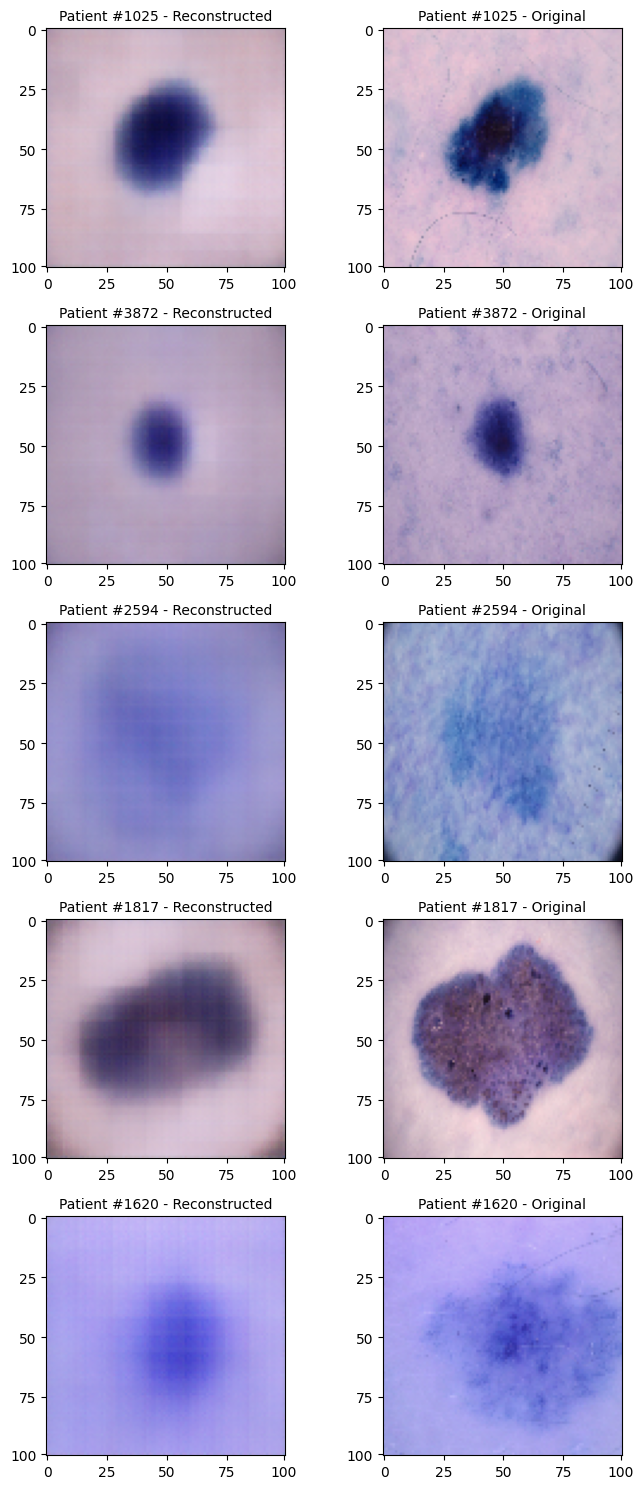

In [56]:
# Select 5 random test patients
np.random.seed(42)
sample_indices = np.random.choice(len(test_spec_img), size=5, replace=False)

# Two columns: Reconstructed vs Original
fig, axes = plt.subplots(5, 2, figsize=(7, 15))

for row_idx, test_idx in enumerate(sample_indices):
    reconstructed = reconstructed_images[test_idx]
    original = X_test_normalized[test_idx]
    
    # Reconstructed
    axes[row_idx, 0].imshow(np.clip(reconstructed, 0, 1))
    axes[row_idx, 0].set_title(f'Patient #{test_idx} - Reconstructed', fontsize=10, fontweight='normal')
    tick_vals = [0, 25, 50, 75, 100]
    tick_pos_x = [0, reconstructed.shape[1]*0.25, reconstructed.shape[1]*0.5, reconstructed.shape[1]*0.75, reconstructed.shape[1]-1]
    tick_pos_y = [0, reconstructed.shape[0]*0.25, reconstructed.shape[0]*0.5, reconstructed.shape[0]*0.75, reconstructed.shape[0]-1]
    axes[row_idx, 0].set_xticks(tick_pos_x)
    axes[row_idx, 0].set_yticks(tick_pos_y)
    axes[row_idx, 0].set_xticklabels([str(v) for v in tick_vals])
    axes[row_idx, 0].set_yticklabels([str(v) for v in tick_vals])
    
    # Original
    axes[row_idx, 1].imshow(np.clip(original, 0, 1))
    axes[row_idx, 1].set_title(f'Patient #{test_idx} - Original', fontsize=10, fontweight='normal')
    tick_pos_x = [0, original.shape[1]*0.25, original.shape[1]*0.5, original.shape[1]*0.75, original.shape[1]-1]
    tick_pos_y = [0, original.shape[0]*0.25, original.shape[0]*0.5, original.shape[0]*0.75, original.shape[0]-1]
    axes[row_idx, 1].set_xticks(tick_pos_x)
    axes[row_idx, 1].set_yticks(tick_pos_y)
    axes[row_idx, 1].set_xticklabels([str(v) for v in tick_vals])
    axes[row_idx, 1].set_yticklabels([str(v) for v in tick_vals])

plt.tight_layout()
plt.show()

In [58]:
# Calculate pixel-wise similarity metrics for all test samples
mse_scores = np.mean((reconstructed_images - X_test_normalized) ** 2, axis=(1, 2, 3))
mae_scores = np.mean(np.abs(reconstructed_images - X_test_normalized), axis=(1, 2, 3))

# Structural similarity (simplified version using correlation)
ssim_scores = []
for i in range(len(reconstructed_images)):
    orig_flat = X_test_normalized[i].flatten()
    recon_flat = reconstructed_images[i].flatten()
    correlation = np.corrcoef(orig_flat, recon_flat)[0, 1]
    ssim_scores.append(correlation)
ssim_scores = np.array(ssim_scores)

avg_mse = np.mean(mse_scores)
avg_mae = np.mean(mae_scores)
avg_ssim = np.mean(ssim_scores)

# Build summary table
metrics_data = [
    {"Metric": "Mean Squared Error (MSE)", "Value": f"{avg_mse:.6f}"},
    {"Metric": "Mean Absolute Error (MAE)", "Value": f"{avg_mae:.6f}"},
    {"Metric": "Pixel Correlation (SSIM proxy)", "Value": f"{avg_ssim:.6f}"},
    {"Metric": "Samples Evaluated", "Value": f"{len(test_spec_img)}"},
]
df_metrics = pd.DataFrame(metrics_data)

# Privacy assessment row
if avg_ssim > 0.7:
    risk = "CRITICAL: High-quality reconstruction (>0.7 correlation)"
elif avg_ssim > 0.5:
    risk = "MODERATE: Recognizable reconstructions (0.5-0.7 correlation)"
else:
    risk = "LOW: Poor reconstruction quality (<0.5 correlation)"

df_metrics = pd.concat([df_metrics, pd.DataFrame([{"Metric": "Privacy Risk", "Value": risk}])], ignore_index=True)

html_metrics = df_metrics.to_html(index=False, classes='table table-striped table-bordered', table_id='recon_summary')
display(HTML("<h3>Data Reconstruction Attack - Results Summary</h3>" + html_metrics))

Metric,Value
Mean Squared Error (MSE),0.006834
Mean Absolute Error (MAE),0.057922
Pixel Correlation (SSIM proxy),0.830421
Samples Evaluated,5313
Privacy Risk,CRITICAL: High-quality reconstruction (>0.7 correlation)


In [63]:
print("TABULAR DATA RECONSTRUCTION (ATTRIBUTE INFERENCE)")

# Configuration
ATTRIBUTE_EPOCHS = 20
ATTRIBUTE_BATCH_SIZE = 32
ATTRIBUTE_LEARNING_RATE = 0.001

print("\nConfiguration:")
print(f"  Input: Tabular-specific embeddings (dimension: {train_spec_tab.shape[1]})")
print(f"  Target Attributes: Age (regression) + Sex (binary classification)")
print(f"  Training epochs: {ATTRIBUTE_EPOCHS}")
print(f"  Batch size: {ATTRIBUTE_BATCH_SIZE}")

TABULAR DATA RECONSTRUCTION (ATTRIBUTE INFERENCE)

Configuration:
  Input: Tabular-specific embeddings (dimension: 64)
  Target Attributes: Age (regression) + Sex (binary classification)
  Training epochs: 20
  Batch size: 32


In [83]:
# 1. DEFINE THE ATTACKER'S INPUT (The Leaked Embeddings)
X_train_attack = train_spec_tab
X_test_attack = test_spec_tab

# 2. DEFINE THE GROUND TRUTH (The Target Attributes)
# Restore Age (Assuming standard scaling: Mean=50, Std=15)
train_age_true = (train_tabular_features[:, 0] * 15) + 50
test_age_true = (test_tabular_features[:, 0] * 15) + 50

# Restore Sex (Binary Feature: <0 is Female, >0 is Male)
train_sex_true = (train_tabular_features[:, 1] > 0).astype(int)
test_sex_true = (test_tabular_features[:, 1] > 0).astype(int)

# 3. CREATE CATEGORIES FOR EVALUATION
def get_age_category(age_array):
    cats = np.zeros(len(age_array), dtype=int)
    cats[age_array < 30] = 0           # Young
    cats[(age_array >= 30) & (age_array <= 60)] = 1  # Middle
    cats[age_array > 60] = 2           # Senior
    return cats

train_age_cat = get_age_category(train_age_true)
test_age_cat = get_age_category(test_age_true)

# Display data preparation summary as tables
attack_input_data = pd.DataFrame([{
    'Dataset': 'Training',
    'Embedding Shape': str(X_train_attack.shape),
    'Samples': len(X_train_attack)
}, {
    'Dataset': 'Test',
    'Embedding Shape': str(X_test_attack.shape),
    'Samples': len(X_test_attack)
}])

ground_truth_data = pd.DataFrame([{
    'Dataset': 'Training',
    'Samples': len(train_age_true),
    'Age Range': f"{train_age_true.min():.1f} - {train_age_true.max():.1f}",
    'Sex Balance': f"{np.mean(train_sex_true)*100:.1f}% Male"
}, {
    'Dataset': 'Test',
    'Samples': len(test_age_true),
    'Age Range': f"{test_age_true.min():.1f} - {test_age_true.max():.1f}",
    'Sex Balance': f"{np.mean(test_sex_true)*100:.1f}% Male"
}])

display(HTML("<h4>Attacker Input (Leaked Embeddings)</h4>"))
display(attack_input_data)

display(HTML("<h4>Ground Truth Attributes (Restored from Normalized Features)</h4>"))
display(ground_truth_data)

,Dataset,Embedding Shape,Samples
0,Training,"(21252, 64)",21252
1,Test,"(5313, 64)",5313


,Dataset,Samples,Age Range,Sex Balance
0,Training,21252,0.5 - 74.0,54.1% Male
1,Test,5313,0.5 - 74.0,54.8% Male


In [84]:
# ATTACK #8: Build Multi-Head Attribute Decoder

# Input: Tabular embedding vector
attribute_input = Input(shape=(train_spec_tab.shape[1],), name='tabular_embedding_input')

# Shared hidden layers
x = Dense(256, activation='relu', name='shared_dense1')(attribute_input)
x = Dropout(0.3, name='shared_dropout1')(x)
x = Dense(128, activation='relu', name='shared_dense2')(x)
x = Dropout(0.2, name='shared_dropout2')(x)

# Age prediction head (multi-class classification: 3 age bins)
age_branch = Dense(64, activation='relu', name='age_dense')(x)
age_output = Dense(3, activation='softmax', name='age_output')(age_branch)

# Sex prediction head (binary classification)
sex_branch = Dense(64, activation='relu', name='sex_dense')(x)
sex_output = Dense(1, activation='sigmoid', name='sex_output')(sex_branch)

# Create multi-head model
attribute_decoder = Model(
    inputs=attribute_input,
    outputs=[age_output, sex_output],
    name='AttributeDecoder'
)

# Compile with combined loss
attribute_decoder.compile(
    optimizer=Adam(learning_rate=ATTRIBUTE_LEARNING_RATE),
    loss={
        'age_output': 'sparse_categorical_crossentropy',
        'sex_output': 'binary_crossentropy'
    },
    loss_weights={
        'age_output': 1.0,
        'sex_output': 1.0
    },
    metrics={
        'age_output': 'accuracy',
        'sex_output': 'accuracy'
    }
)

# Extract model summary and display as HTML table
summary_data = []
for layer in attribute_decoder.layers:
    layer_type = layer.__class__.__name__
    
    # Get output shape properly
    if hasattr(layer, 'output_shape') and layer.output_shape is not None:
        if isinstance(layer.output_shape, tuple):
            shape_str = str(layer.output_shape)
        else:
            shape_str = str(layer.output_shape)
    elif hasattr(layer, 'output') and layer.output is not None:
        try:
            shape_str = str(layer.output.shape)
        except:
            shape_str = 'N/A'
    else:
        shape_str = 'N/A'
    
    params = layer.count_params() if hasattr(layer, 'count_params') else 0
    
    summary_data.append({
        'Layer': layer.name,
        'Type': layer_type,
        'Output Shape': shape_str,
        'Params': f'{params:,}'
    })

df_summary = pd.DataFrame(summary_data)
df_summary['Trainable'] = ['Yes' if layer.trainable else 'No' for layer in attribute_decoder.layers]

# Calculate total params
total_params = sum([layer.count_params() for layer in attribute_decoder.layers if hasattr(layer, 'count_params')])
trainable_params = sum([layer.count_params() for layer in attribute_decoder.layers if hasattr(layer, 'count_params') and layer.trainable])
non_trainable_params = total_params - trainable_params

# Display as HTML table
html_table = df_summary.to_html(index=False, classes='table table-striped table-bordered', 
                                table_id='attribute_decoder_summary', escape=False)
html_table += f'<br><b>Total params:</b> {total_params:,}<br>'
html_table += f'<b>Trainable params:</b> {trainable_params:,}<br>'
html_table += f'<b>Non-trainable params:</b> {non_trainable_params:,}<br>'

display(HTML(html_table))


Layer,Type,Output Shape,Params,Trainable
tabular_embedding_input,InputLayer,"(None, 64)",0,Yes
shared_dense1,Dense,"(None, 256)","16,640",Yes
shared_dropout1,Dropout,"(None, 256)",0,Yes
shared_dense2,Dense,"(None, 128)","32,896",Yes
shared_dropout2,Dropout,"(None, 128)",0,Yes
age_dense,Dense,"(None, 64)","8,256",Yes
sex_dense,Dense,"(None, 64)","8,256",Yes
age_output,Dense,"(None, 3)",195,Yes
sex_output,Dense,"(None, 1)",65,Yes


In [89]:
# Train the decoder
attribute_history = attribute_decoder.fit(
    train_spec_tab,
    {'age_output': train_age_category, 'sex_output': train_sex_binary},
    validation_split=0.1,
    epochs=ATTRIBUTE_EPOCHS,
    batch_size=ATTRIBUTE_BATCH_SIZE,
    verbose=1
)

print("Attribute decoder training completed")

# Evaluate on test set
test_results = attribute_decoder.evaluate(
    test_spec_tab,
    {'age_output': test_age_category, 'sex_output': test_sex_binary},
    verbose=0
)

Epoch 1/20
598/598 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - age_output_accuracy: 0.9954 - age_output_loss: 0.0124 - loss: 0.0129 - sex_output_accuracy: 0.9996 - sex_output_loss: 5.1520e-04 - val_age_output_accuracy: 0.9976 - val_age_output_loss: 0.0046 - val_loss: 0.0047 - val_sex_output_accuracy: 1.0000 - val_sex_output_loss: 6.0206e-09
Epoch 2/20
598/598 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - age_output_accuracy: 0.9944 - age_output_loss: 0.0149 - loss: 0.0149 - sex_output_accuracy: 1.0000 - sex_output_loss: 1.1145e-05 - val_age_output_accuracy: 0.9976 - val_age_output_loss: 0.0059 - val_loss: 0.0059 - val_sex_output_accuracy: 1.0000 - val_sex_output_loss: 3.6268e-08
Epoch 3/20
598/598 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - age_output_accuracy: 0.9963 - age_output_loss: 0.0116 - loss: 0.0120 - sex_output_accuracy: 0.9999 - sex_output_loss: 4.1062e-04 - val_age_output_accuracy: 0.9849 - val_age_output_loss: 0.0327 - val_loss: 0.0325 - val_sex_output_accuracy: 1.0000 - val_sex_output_loss: 1.4164e-0

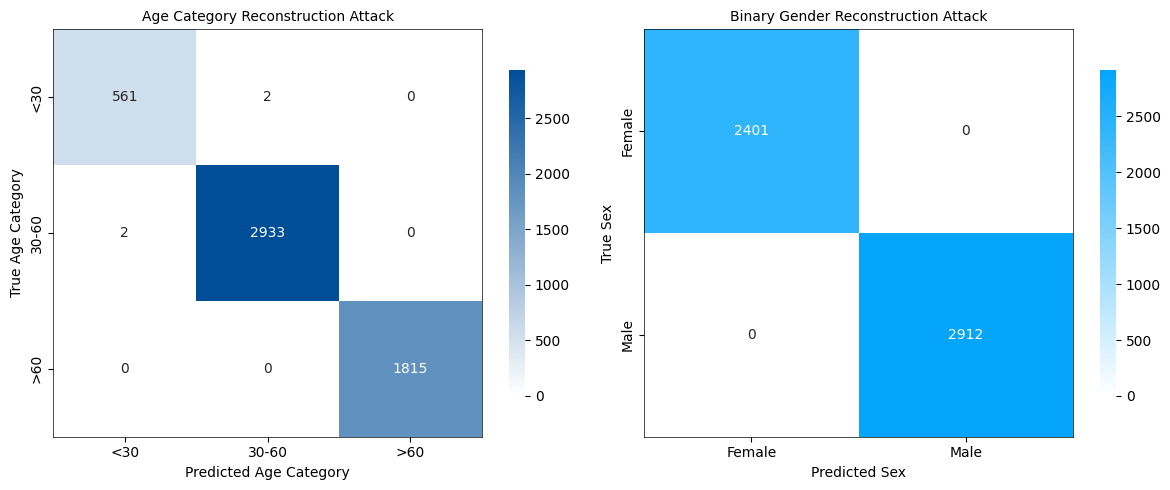

,Metric,Test Performance,Inference Accuracy,Baseline (Random),Improvement
0,Age Category Accuracy,0.9992 (99.92%),0.9992 (99.92%),0.5524 (55.24%),44.68%
1,Sex Accuracy,1.0000 (100.00%),1.0000 (100.00%),0.5481 (54.81%),45.19%


In [107]:
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.patches import Rectangle
from IPython.display import HTML, display

# Create custom colormaps: white to specified colors
age_colors = ['#FFFFFF', '#004E98']  # white to dark blue
sex_colors = ['#FFFFFF', '#04A5FA']  # white to light blue
age_cmap = LinearSegmentedColormap.from_list('age_cmap', age_colors, N=256)
sex_cmap = LinearSegmentedColormap.from_list('sex_cmap', sex_colors, N=256)

# Handle variable name consistency (check both naming conventions)
if 'test_age_category' not in locals():
    test_age_category = test_age_cat
if 'test_sex_binary' not in locals():
    test_sex_binary = test_sex_true

# Generate predictions for test set (needed for visualization)
age_pred_probs, sex_pred_probs = attribute_decoder.predict(test_spec_tab, verbose=0)
age_pred_category = np.argmax(age_pred_probs, axis=1)
sex_pred_binary = (sex_pred_probs.flatten() > 0.5).astype(int)

# Calculate accuracy metrics
age_accuracy = np.mean(age_pred_category == test_age_category)
sex_accuracy = np.mean(sex_pred_binary == test_sex_binary)

# Calculate baselines (random guessing based on class distribution)
age_class_counts = np.bincount(test_age_category)
age_baseline = np.max(age_class_counts) / len(test_age_category)
sex_class_counts = np.bincount(test_sex_binary)
sex_baseline = np.max(sex_class_counts) / len(test_sex_binary)

# Create figure with two plots
fig = plt.figure(figsize=(12, 5))

# Plot A: Age Category Confusion Matrix
ax1 = plt.subplot(1, 2, 1)

# Calculate confusion matrix for age
age_cm = confusion_matrix(test_age_category, age_pred_category)
sns.heatmap(age_cm, annot=True, fmt='d', cmap=age_cmap, ax=ax1, 
            xticklabels=['<30', '30-60', '>60'],
            yticklabels=['<30', '30-60', '>60'],
            linewidths=0, cbar_kws={'shrink': 0.8})

# Add border around the plot
for spine in ax1.spines.values():
    spine.set_visible(True)
    spine.set_edgecolor('black')
    spine.set_linewidth(0.5)

ax1.set_xlabel('Predicted Age Category', fontsize=10, fontweight='normal')
ax1.set_ylabel('True Age Category', fontsize=10, fontweight='normal')
ax1.set_title('Age Category Reconstruction Attack', 
              fontsize=10, fontweight='normal')


# Plot B: Sex Prediction Confusion Matrix
ax2 = plt.subplot(1, 2, 2)

# Calculate confusion matrix for sex
sex_cm = confusion_matrix(test_sex_binary, sex_pred_binary)
sns.heatmap(sex_cm, annot=True, fmt='d', cmap=sex_cmap, ax=ax2, 
            xticklabels=['Female', 'Male'],
            yticklabels=['Female', 'Male'],
            linewidths=0, cbar_kws={'shrink': 0.8})

# Add border around the plot
for spine in ax2.spines.values():
    spine.set_visible(True)
    spine.set_edgecolor('black')
    spine.set_linewidth(0.5)

ax2.set_xlabel('Predicted Sex', fontsize=10, fontweight='normal')
ax2.set_ylabel('True Sex', fontsize=10, fontweight='normal')
ax2.set_title('Binary Gender Reconstruction Attack', 
              fontsize=10, fontweight='normal')


plt.tight_layout()
plt.show()


# Create results summary table
results_data = pd.DataFrame([
    {
        'Metric': 'Age Category Accuracy',
        'Test Performance': f"{test_results[3]:.4f} ({test_results[3]*100:.2f}%)",
        'Inference Accuracy': f"{age_accuracy:.4f} ({age_accuracy*100:.2f}%)",
        'Baseline (Random)': f"{age_baseline:.4f} ({age_baseline*100:.2f}%)",
        'Improvement': f"{(age_accuracy - age_baseline)*100:.2f}%"
    },
    {
        'Metric': 'Sex Accuracy',
        'Test Performance': f"{test_results[4]:.4f} ({test_results[4]*100:.2f}%)",
        'Inference Accuracy': f"{sex_accuracy:.4f} ({sex_accuracy*100:.2f}%)",
        'Baseline (Random)': f"{sex_baseline:.4f} ({sex_baseline*100:.2f}%)",
        'Improvement': f"{(sex_accuracy - sex_baseline)*100:.2f}%"
    }
])

display(HTML("<h3>Attribute Inference Attack Results Summary</h3>"))
display(results_data)